In [3]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
 
import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

import lightgbm as lgb
import xgboost as xgb 

from bs4 import BeautifulSoup
    
import scipy
import statsmodels.api
import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os
import lightgbm as lgb

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import spacy

from spellchecker import SpellChecker
import re
import nltk

Using TensorFlow backend.


# 1. Data Load

In [4]:
essay = pd.read_csv("data/essay_dataset.csv")

## 1) 데이터 준비

### (1) 비식별 데이터 처리

#### - 정규표현식 정의

In [5]:
# @정규표현식

searcher = re.compile('@')

#### - 처리 예시

In [6]:
# 원본

essay.loc[1,"essay"]

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

In [7]:
# 처리 후

searcher.sub('',essay.loc[1,"essay"])

"Dear CAPS1 CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the inte

#### - 전처리

In [8]:
essay["essay"] = essay["essay"].apply(lambda x : searcher.sub('',x))

### (2) Vectorization

In [742]:
def vect_tokenizer(text):
    return nltk.tokenize.word_tokenize(text)

In [743]:
text = essay["essay"].copy()

In [744]:
text = text.dropna()

In [745]:
## CountVectorizer로 문자 : 숫자로 이루어진 색인 사전을 만든다.
## 이미 만들어진 색인사전을 이용해도 됩니다.

vect = CountVectorizer(tokenizer = vect_tokenizer ,min_df = 1, analyzer = "word")
vect.fit(text)
vocabulary = vect.vocabulary_
# CLS와 EOS 토큰을 각각 정의한다.
vocabulary['CLS'] = len(vocabulary) + 1
vocabulary['EOS'] = len(vocabulary) + 2
DataFrame([vect.vocabulary_]).to_csv("data/색인사전.csv",encoding="utf-8",index=False)

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


# 2. EDA

## 1) Essay_1

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [2705]:
essay_1 = essay[essay["essay_set"] == 1]

In [2706]:
essay_1["sen_len"] = essay_1["essay"].apply(lambda x : len(x))

<ipython-input-2706-aaabe0e83da7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_1["sen_len"] = essay_1["essay"].apply(lambda x : len(x))


#### - 고득점 사레와 저득점 사례 비교

In [2707]:
print("==== 고득점 사례 ======")
print(" ")
print(essay_1["essay"][1])
print(" ")
print("===== 저득점 사례======")
print(" ")
print(essay_1.loc[21,"essay"])

==== 고득점 사례 ======
 
Dear CAPS1 CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we d

저득점 사례는 전반적으로 문장길이가 상대적으로 짧은 것을 확인할 수 있다.

#### - 점수별 분포

<AxesSubplot:>

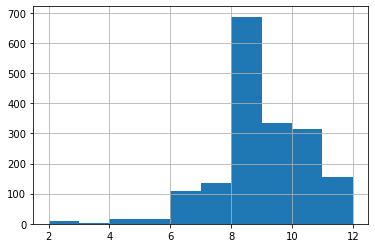

In [2708]:
essay_1["score"].hist()

대부분이 8 ~ 10점 사이에 몰려있다.

불균형을 해결하기 위해 고 / 중 / 저로 묶어줄 필요가 있어보인다.

## (1) 문장 길이

In [2709]:
essay_1.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,2,152.700000
1,3,316.000000
2,4,518.941176
3,5,728.705882
4,6,1038.563636
5,7,1363.185185
6,8,1812.946143
7,9,2248.116766
8,10,2580.629747
9,11,2922.348624


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

In [2854]:
essay_1.loc[essay_1["score"] < 5,"score_new"] = 1

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [2855]:
essay_1.loc[(essay_1["score"] >= 5) & (essay_1["score"] < 9),"score_new"] = 2

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [2856]:
essay_1.loc[essay_1["score"] >= 9,"score_new"] = 3

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


1 ~ 12점 척도인 점수를 저, 중, 고득점으로 구분

1, 2, 3 -> 1

4, 5, 6, 7, 8 -> 2

9, 10, 11, 12 -> 3

<AxesSubplot:>

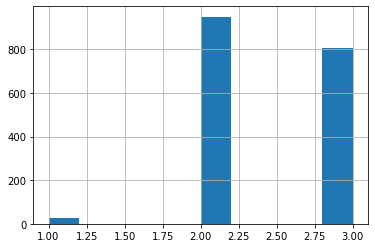

In [2857]:
essay_1["score_new"].hist()

In [2858]:
model = ols('sen_len ~ score_new',essay_1).fit()
anova_result = anova_lm(model)

In [2859]:
model.conf_int()

,0,1
Intercept,-316.092902,-101.472805
score_new,871.642119,957.744543


#### - shapiro-wilks 정규성 검정

In [2860]:
essay_1["resid"] = model.resid

<ipython-input-2860-0eb8e966e6c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_1["resid"] = model.resid


In [2861]:
essay_1["fitted"] = model.fittedvalues

<ipython-input-2861-81f367cdc212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_1["fitted"] = model.fittedvalues


In [2862]:
essay_1.groupby(["score_new"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score_new
1.0       (0.9608597755432129, 0.36536046862602234)
2.0       (0.9976129531860352, 0.18587706983089447)
3.0    (0.9720934629440308, 2.7401999072584893e-11)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

#### - QQPLOT

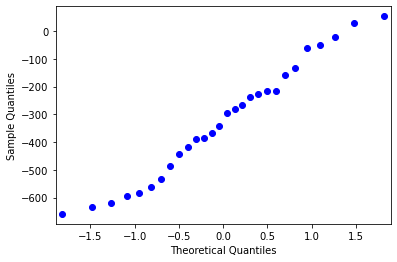

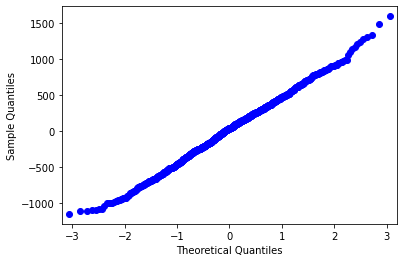

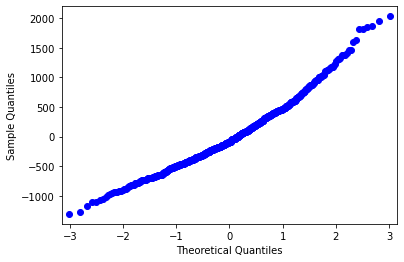

In [2863]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_1.groupby(["score_new"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규분포를 따르는 것으로 보인다.

#### - 등분산검정

In [2864]:
scipy.stats.bartlett(essay_1.loc[essay_1["score_new"] == 1,"sen_len"],
                    essay_1.loc[essay_1["score_new"] == 2,"sen_len"],
                    essay_1.loc[essay_1["score_new"] == 3,"sen_len"])

BartlettResult(statistic=38.71279266253595, pvalue=3.923050365566653e-09)

각 집단간의 분산은 동일하지 않다. 등분산성을 가정하는 기존의 ANOVA가 아닌 수정된 Welch ANOVA를 이용한다.

#### -ANOVA(WELCH)

In [2865]:
import pingouin as pg

pg.welch_anova(dv='sen_len', between='score_new', data=essay_1)

,Source,ddof1,ddof2,F,p-unc,np2
0,score_new,2,82.720247,1429.971189,7.000476e-65,0.497738


p-value는 충분히 작은 7.000476e-65이다. 따라서 적어도 한개의 평균은 다르다는 결론을 내릴 수 있다.

#### 결론 1 : 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 품사 태깅 및 비율 확인

가설 : 에세이에 존재하는 모든 품사들과 1)문장 갯수 or 2) 단어 갯수와의 비율을 산정한다.

적어도 한 개의 품사 비율은 점수를 예측하는데 유의미한 정보를 포함하고 있을 것이다.

#### - Boruta 알고리즘

제한된 분석 시간 하에서 유의미한 정보를 포함하고 있는 품사를 도출하기 위해 Boruta 알고리즘을 활용한다.

In [2866]:
sp = spacy.load('en_core_web_sm')

각 에세이에서 단어, 품사(대), 품사(소), 원형, 문장 성분을 추출한다.

해당 데이터를 Essay_id로 묶는다.

In [ ]:
pos_tagging = [list(map(lambda x : 
                       [i, x.text, x.pos_, x.tag_, x.lemma_, x.dep_], 
                       sp(essay_1["essay"][i]))) 
              for i in range(0, len(essay_1))]

In [ ]:
result = DataFrame(columns = ["essay_id","word","pos","tag","lemma","depend"])

for i in range(0, len(pos_tagging)):
    result = pd.concat([result, DataFrame(pos_tagging[i], columns = ["essay_id","word","pos","tag","lemma","depend"])])

result의 포함된 결과물은 다음과 같다.

essay_id : 에세이 번호

word : 단어

pos : 품사(대분류, 명사 등)

tag : 품사(소분류, 대명사 등)

lemma : 원형

depend ; 문장 성분(주어, 목적어 등)

In [2726]:
# 결과물 예시

result

,essay_id,word,pos,tag,lemma,depend
0,0,Dear,ADJ,JJ,dear,amod
1,0,local,ADJ,JJ,local,amod
2,0,newspaper,NOUN,NN,newspaper,npadvmod
3,0,",",PUNCT,",",",",punct
4,0,I,PRON,PRP,I,nsubj
...,...,...,...,...,...,...
238,1782,anything,PRON,NN,anything,dobj
239,1782,with,ADP,IN,with,prep
240,1782,a,DET,DT,a,det
241,1782,computer,NOUN,NN,computer,pobj


In [2727]:
sen_count = essay_1["essay"].apply(lambda x : len(nltk.sent_tokenize(x))).reset_index(name = "sen_count")

sen_count.columns = ["essay_id","sen_count"]

In [2728]:
len_count = result.groupby("essay_id")["lemma"].count().reset_index()

len_count.columns = ["essay_id","len_count"]

In [2729]:
## 각 품사를 총 단어 갯수로 나눔

count_result = DataFrame({"essay_id" : result["essay_id"].unique()})

for i in result["tag"].unique():

    test = result[result["tag"] == i]

    lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()
    
    count = pd.merge(lemma_count, len_count)

    count["{}_ratio".format(i)] = count["lemma"] / count["len_count"]
    
    count_result = pd.merge(count_result, count, how = "left")


In [2730]:
## NaN인 경우는 해당 품사가 없다는 의미이므로 0으로 처리해준다.

count_result = count_result.fillna(0)

In [2731]:
count_result = pd.merge(count_result, essay_1[["essay_id","score_new","score"]])

Boruta 알고리즘은 RF를 활용하여 1) 의미를 갖는 실제 변수 2) Random Shuffle 하여 의미를 가지지 않는 변수 
간의 변수 중요도를 구해 비교한다.

Random Shuffle한 변수보다 실제 변수의 변수 중요도가 낮다면, 그 변수는 예측에 도움이 되지 않는 변수로 간주할 수 있다.

In [2732]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y

X = count_result.loc[:,"JJ_ratio" : "AFX_ratio"].values
y = count_result["score_new"].values
y = y.ravel()


rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

feat_selector.fit(X, y)

feat_selector.support_

feat_selector.ranking_

X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	49
I

#### 결론 1 : Boruta 알고리즘을 통해 점수에 중요도를 갖는 품사(tag)를 추출하고자 했으나 무의미한 것으로 도출됬다.

#### - 부사절 접속사(Beacuse, while,  if 등)

가설 : 에세이 1은 컴퓨터가 인류에게 도움이 되는지 아닌지 스탠스를 정해 설득문을 작성하는게 주제이다.

#### 따라서 훌륭한 논증을 펼친 에세이일수록

Because, While, if 등 주로 이유와 조건들을 제시하는 접속사인 부사절 접속사가 다수 포함되어 있을 것이라고 가설을 세울 수 있다.

In [2733]:
#SCONJ는 부사절 접속사를 의미한다.

result = result.reset_index(drop = True)

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2734]:
count = pd.merge(lemma_count, len_count)

count["SCONJ_noun_ratio"] = count["lemma"] / count["len_count"]

count = pd.merge(count, essay_1[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","len_count","SCONJ_noun_ratio","score_new","score"]]

각 에세이별로 총 단어 갯수(len_count)와 그 중 부사절 접속사의 갯수를 비율로 산출한다(SCONJ_noun_ratio)

In [2735]:
# 부사절 / 단어 갯수 비율

print("하위권 : " , count[count["score_new"] == 1]["SCONJ_noun_ratio"].mean())
print("중위권 : ", count[count["score_new"] == 2]["SCONJ_noun_ratio"].mean())
print("상위권 : ", count[count["score_new"] == 3]["SCONJ_noun_ratio"].mean())

하위권 :  0.021680233465913124
중위권 :  0.02095216656053915
상위권 :  0.020483401153512066


상 / 중 / 하 범위별로 부사절 / 단어 갯수 비율에 뚜렷한 패턴을 찾기 어렵다.

#### 결론 2 : 하 / 중 / 상 점수간 부사절 접속사 / 단어 갯수 비율은 유의미한 차이가 없다.

In [2736]:
result = result.reset_index(drop = True)

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2737]:
count = pd.merge(lemma_count, sen_count)

count["SCONJ_ratio"] = count["lemma"] / count["sen_count"]

count = pd.merge(count, essay_1[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","sen_count","SCONJ_ratio","score_new","score"]]

In [2738]:
# 부사절 / 문장 갯수 비율

print("하위권 : " , count[count["score_new"] == 1]["SCONJ_ratio"].mean())
print("중위권 : ", count[count["score_new"] == 2]["SCONJ_ratio"].mean())
print("상위권 : ", count[count["score_new"] == 3]["SCONJ_ratio"].mean())

하위권 :  0.4286676471203325
중위권 :  0.4401334256678887
상위권 :  0.4024447412500124


#### 결론 3 : 하 / 중 / 상 점수간 부사절 접속사 / 문장 갯수 비율은 유의미한 차이가 없다.

#### - Because 등을 포함하는 부사절 접속사 / 문장 갯수(상위 점수 한정)

가설 : 소결론 2에서 하 / 중 / 상 간 점수간 유의미한 차이가 없는 것으로 도출되었지만

상위권 점수 한정으로 9 ~ 12점의 점수 차이를 결정짓는것은 여전히 부사절 접속사의 비율이라고 가설을 세울 수 있다.

In [2739]:
essay_1_3 = essay_1[essay_1["score_new"] == 3]

In [2740]:
result_1_3 = pd.merge(essay_1_3, result)

In [2741]:
#SCONJ는 부사절 접속사를 의미한다.

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result_1_3, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2742]:
count = pd.merge(lemma_count, sen_count)

count["SCONJ_ratio"] = count["lemma"] / count["sen_count"]

count = pd.merge(count, essay_1[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","sen_count","SCONJ_ratio","score_new","score"]]



In [2743]:
print("부사절 접속사 / 총 문장 갯수")
print("9점 : " , count[count["score"] == 9]["SCONJ_ratio"].mean())
print("10점 : ", count[count["score"] == 10]["SCONJ_ratio"].mean())
print("11점 : ", count[count["score"] == 11]["SCONJ_ratio"].mean())
print("12점 : ", count[count["score"] == 12]["SCONJ_ratio"].mean())

부사절 접속사 / 총 문장 갯수
9점 :  0.3775442580480608
10점 :  0.4085960388924973
11점 :  0.4373766397840179
12점 :  0.4570753272333037


점수가 올라갈수록 비율이 높아지는 현상을 보인다. 고무적이지만 정말로 차이가 있는지 검정이 필요하다.

In [2744]:
# ANOVA 적합

model = ols('SCONJ_ratio ~ score',count).fit()
anova_result = anova_lm(model)

기본 가정 충족 여부 검정 : 

ANOVA는 1) 잔차의 정규성 2) 등분산성을 만족해야한다.

해당 가정을 만족하는지 확인한다.

In [2745]:
count["resid"] = model.resid

In [2746]:
count["fitted"] = model.fittedvalues

In [2747]:
count.groupby(["score"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score
9       (0.749398946762085, 4.895722779512471e-22)
10     (0.8677321672439575, 9.387711682440326e-16)
11     (0.7241158485412598, 5.936696446939838e-13)
12    (0.8691331148147583, 0.00010057875624625012)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

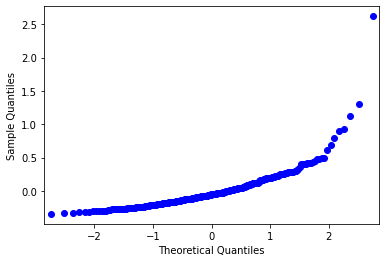

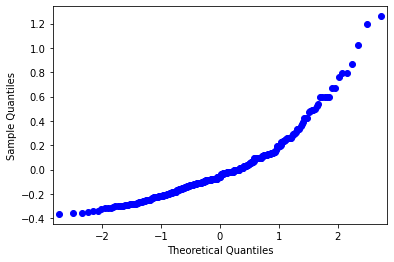

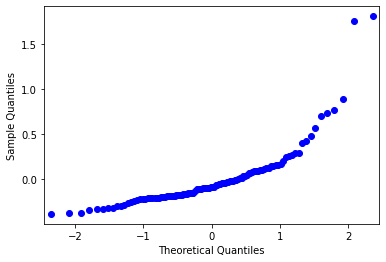

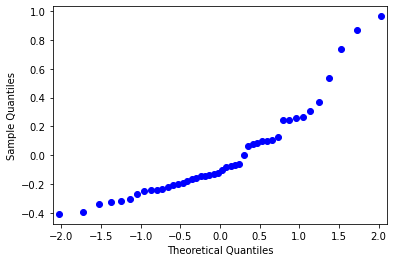

In [2748]:
## qqplot

import numpy as np
import statsmodels.api as sm
import pylab

count.groupby(["score"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규성을 만족하지 못하고 있다.

#### ANOVA는 사용할 수가 없다. 따라서 대안적 방법으로 각 짝별로 T-test를 실시한다.

In [2749]:
from itertools import permutations
a = count["score"].unique()
permute = list(permutations(a,2))


In [2750]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(count.loc[count["score"] == i[0],"SCONJ_ratio"], 
                              count.loc[count["score"] == i[1],"SCONJ_ratio"],
                              equal_var = False)[1])

In [2752]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(9, 10)",0.134427,False
1,"(9, 12)",0.109927,False
2,"(9, 11)",0.105787,False
3,"(10, 9)",0.134427,False
4,"(10, 12)",0.324317,False
5,"(10, 11)",0.431584,False
6,"(12, 9)",0.109927,False
7,"(12, 10)",0.324317,False
8,"(12, 11)",0.732365,False
9,"(11, 9)",0.105787,False


모든 짝에서 평균 차이를 검정해본 결과 귀무가설을 기각하지 못했다.

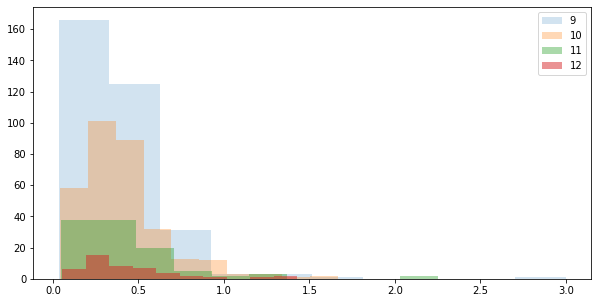

In [2753]:
plt.figure(figsize = (10,5))
plt.hist(count.loc[count["score"] == 9, "SCONJ_ratio"], label = '9', alpha = 0.2)
plt.hist(count.loc[count["score"] == 10, "SCONJ_ratio"], label = '10', alpha = 0.3)
plt.hist(count.loc[count["score"] == 11, "SCONJ_ratio"], label = '11', alpha = 0.4)
plt.hist(count.loc[count["score"] == 12, "SCONJ_ratio"], label = '12', alpha = 0.5)

plt.legend()

히스토그램을 그려보면, 사실 분포가 굉장히 겹치는 양태를 확인할 수 있다.

#### 결론 4 : 상위 점수로 한정지어도, 부사절 접속사 갯수 / 문장 갯수의 비율은 점수별로 유의미한 차이가 없다. 

#### - Because 등을 포함하는 부사절 접속사 / 단어 갯수(상위 점수 한정)

바로 위에서 실시했던것이 문장 갯수를 분모로 둔 것이라면, 여기서는 단어 갯수를 분모로 둔다.

In [2754]:

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result_1_3, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2755]:
count = pd.merge(lemma_count, len_count)

count["SCONJ_noun_ratio"] = count["lemma"] / count["len_count"]

count = pd.merge(count, essay_1_3[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","len_count","SCONJ_noun_ratio","score_new","score"]]

In [2756]:
# 부사절 / 단어 갯수 비율

print("9점 : " , count[count["score"] == 9]["SCONJ_noun_ratio"].mean())
print("10점 : ", count[count["score"] == 10]["SCONJ_noun_ratio"].mean())
print("11점 : ", count[count["score"] == 11]["SCONJ_noun_ratio"].mean())
print("12점 : ", count[count["score"] == 12]["SCONJ_noun_ratio"].mean())

9점 :  0.01939416682376005
10점 :  0.021167345716567792
11점 :  0.020900705132723338
12점 :  0.022649051289682264


In [2757]:
# T-test

from itertools import permutations
a = count["score"].unique()
permute = list(permutations(a,2))


In [2758]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(count.loc[count["score"] == i[0],"SCONJ_noun_ratio"], 
                              count.loc[count["score"] == i[1],"SCONJ_noun_ratio"],equal_var = False)[1])

In [2759]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(9, 10)",0.024847,True
1,"(9, 12)",0.075321,False
2,"(9, 11)",0.184576,False
3,"(10, 9)",0.024847,True
4,"(10, 12)",0.418051,False
5,"(10, 11)",0.819190,False
6,"(12, 9)",0.075321,False
7,"(12, 10)",0.418051,False
8,"(12, 11)",0.382113,False
9,"(11, 9)",0.184576,False


점수 ( 9 - 10점) 짝을 제외하고 모든 짝에서 평균 차이가 유의미하지 않은 것으로 나타났다.

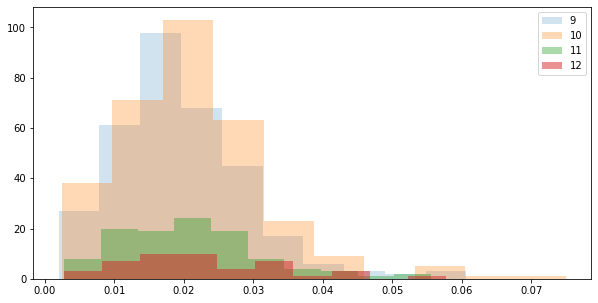

In [2760]:
plt.figure(figsize = (10,5))
plt.hist(count.loc[count["score"] == 9, "SCONJ_noun_ratio"], label = '9', alpha = 0.2)
plt.hist(count.loc[count["score"] == 10, "SCONJ_noun_ratio"], label = '10', alpha = 0.3)
plt.hist(count.loc[count["score"] == 11, "SCONJ_noun_ratio"], label = '11', alpha = 0.4)
plt.hist(count.loc[count["score"] == 12, "SCONJ_noun_ratio"], label = '12', alpha = 0.5)

plt.legend()

히스토그램을 그려보면

(9 - 10) 짝은 분포에 약간의 차이가 있어보이나, 나머지는 대부분 동일한 양상을 확인 가능하다.

#### 결론 5 : 상위 점수로 한정지어도, 부사절 접속사 갯수 / 단어 갯수의 비율은 점수별로 유의미한 차이가 없다. 

### (4) Argument Feature

가설 : 부사절 접속사 전체가 아닌, 몇개의 접속사 (if, since, when, as, because, unless)를 추려 비율을 산정하면

유의미한 차이가 존재할 수 있다.

#### - 선정된 접속사 / 문장 갯수 비율

In [2774]:
result = result.reset_index(drop = True)

lemma_reason = DataFrame({"lemma" : ["if","since","when","as","because","unless"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2775]:
sen_count = essay_1["essay"].apply(lambda x : len(nltk.sent_tokenize(x))).reset_index(name = "sen_count")

sen_count.columns = ["essay_id","sen_count"]

In [2776]:
count = pd.merge(lemma_count, sen_count)

count["lemma_sen_ratio"] = count["lemma"] / count["sen_count"]

count = pd.merge(count, essay_1[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","sen_count","lemma_sen_ratio","score_new","score"]]

In [2777]:
# 조건&이유 접속사 / 문장 갯수 비율

print("하위권 : " , count[count["score_new"] == 1]["lemma_sen_ratio"].mean())
print("중위권 : ", count[count["score_new"] == 2]["lemma_sen_ratio"].mean())
print("상위권 : ", count[count["score_new"] == 3]["lemma_sen_ratio"].mean())

하위권 :  0.32875131475515107
중위권 :  0.3329829350239216
상위권 :  0.31480698443464256


#### - 조건&이유 접속사 / 단어 갯수 비율(상위권)

In [2778]:
result = result.reset_index(drop = True)

lemma_reason = DataFrame({"lemma" : ["if","since","when","because","unless"]})

test = pd.merge(lemma_reason, result_1_3, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2779]:
count = pd.merge(lemma_count, len_count)

count["SCONJ_noun_ratio"] = count["lemma"] / count["len_count"]

count = pd.merge(count, essay_1_3[["essay_id","score_new","score"]])

count = count[["essay_id","lemma","len_count","SCONJ_noun_ratio","score_new","score"]]

In [2780]:
# 부사절 / 단어 갯수 비율

print("9점 : " , count[count["score"] == 9]["SCONJ_noun_ratio"].mean())
print("10점 : ", count[count["score"] == 10]["SCONJ_noun_ratio"].mean())
print("11점 : ", count[count["score"] == 11]["SCONJ_noun_ratio"].mean())
print("12점 : ", count[count["score"] == 12]["SCONJ_noun_ratio"].mean())

9점 :  0.012621287269452499
10점 :  0.013493487324935041
11점 :  0.012783483872999095
12점 :  0.015568866549967954


#### 결론 6 : 상위 점수로 한정지어도, 부사절 접속사 갯수 / 단어 갯수의 비율은 점수별로 유의미한 차이가 없다. 

EDA 결과 문장 길이가 써볼법한 추가 파생변수로 도출되었다. 

동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [2781]:
# 훈련 DF 생성

encoding_result = DataFrame()

for i in essay_1["essay_id"].unique():
    text = essay_1.loc[essay_1["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_1, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")


In [2783]:
# Baseline


columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.7376681614349776

In [2784]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.5403587443946188

검증 결과 문장 길이를 추가한 모델의 성능이 더 좋은 것으로 나타났다.

#### 변수중요도

가장 성능이 좋았던 sen_len, JJ_ratio 포함 모델의 변수 중요도는 아래와 같다.

In [2627]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)

,col,importance
39755,sen_len,0.511178
39756,JJ_ratio,0.013626
14845,14845,0.009910
292,292,0.005242
6189,6189,0.005135
...,...,...
13789,13789,0.000000
13790,13790,0.000000
13791,13791,0.000000
13792,13792,0.000000


# 2) Essay_2

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [2785]:
essay_2 = essay[essay["essay_set"] == 2].reset_index(drop = True)

In [2786]:
essay_2["sen_len"] = essay_2["essay"].apply(lambda x : len(x))

#### - 고득점 사레와 저득점 사례 비교

In [2284]:
print("==== 고득점 사례 ======")
print(" ")
print(essay_2["essay"][1783])
print(" ")
print("===== 저득점 사례======")
print(" ")
print(essay_2.loc[1784,"essay"])

==== 고득점 사례 ======
 
Offensive things should be taken off for many reason that will be explained later on. Things in magazines shoud be appropriate for people to see. The first reason why they should be removed from the shelves is it might be offending to someone important like the president of the ORGANIZATION1 or the CAPS1 of your state.      If the subjects in the reading material are offensive to someone they should say something to defend themselves. If they don't speak up no one will think to change anything.     What I don't understand is why people would let that ridiculous stuff be put in the magazines and music and movies anyway.Even though movies are kind of different. Movies are mostly just made up ideas that people come up with. So if people are offended it is just pretend to begin with.      Offending things in books well the author probably has a reason for it. It might be something that is offending yet people need to know this in case it has to do with someone you know

저득점 사례는 전반적으로 문장길이가 상대적으로 짧은 것을 확인할 수 있다.

#### - 점수별 분포

<AxesSubplot:>

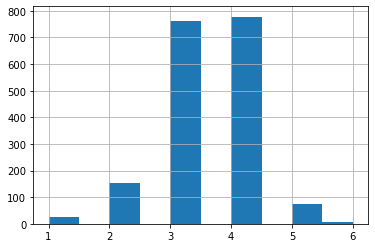

In [2285]:
essay_2["score"].hist()

대부분은 3점 ~ 4점 사이에 몰려있다.

## (1) 문장 길이

In [2286]:
essay_2.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,1,560.000000
1,2,984.130719
2,3,1760.023591
3,4,2541.664524
4,5,3372.080000
5,6,3994.000000


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

In [2287]:
model = ols('sen_len ~ score',essay_2).fit()
anova_result = anova_lm(model)

#### - shapiro-wilks 정규성 검정

In [2288]:
essay_2["resid"] = model.resid

In [2289]:
essay_2["fitted"] = model.fittedvalues

In [2290]:
essay_2.groupby(["score"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score
1     (0.7687922716140747, 9.49041495914571e-05)
2    (0.866833508014679, 1.9519905136711202e-10)
3    (0.9464340806007385, 5.428258817478059e-16)
4     (0.9630738496780396, 4.18119721788332e-13)
5      (0.9734207987785339, 0.11559771001338959)
6       (0.8833318948745728, 0.2416532337665558)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

#### - QQPLOT

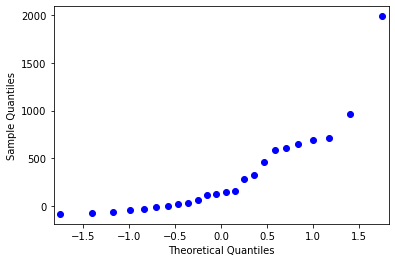

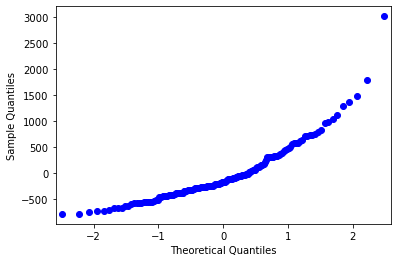

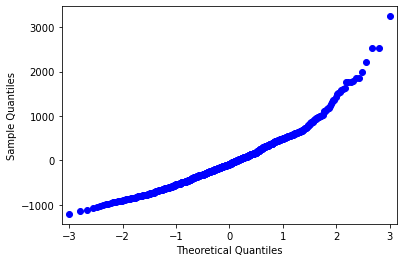

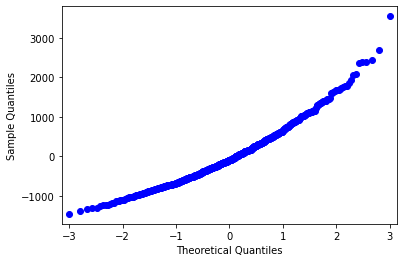

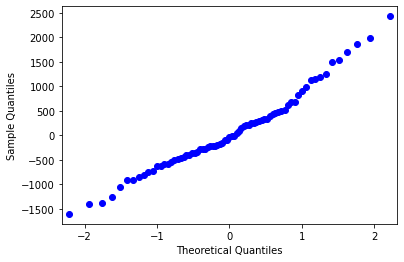

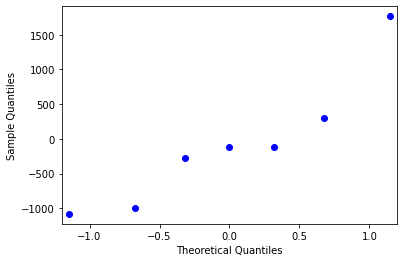

In [2291]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_2.groupby(["score"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규분포를 따르지 않는다


#### ANOVA는 사용할 수가 없다. 따라서 대안적 방법으로 각 짝별로 T-test를 실시한다.

In [2292]:
from itertools import permutations
a = essay_2["score"].unique()
permute = list(permutations(a,2))


In [2293]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_2.loc[essay_2["score"] == i[0],"sen_len"], 
                              essay_2.loc[essay_2["score"] == i[1],"sen_len"],
                              equal_var = False)[1])

In [2294]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(4, 1)",2.431199e-17,True
1,"(4, 2)",2.921587e-87,True
2,"(4, 5)",4.884587e-13,True
3,"(4, 3)",1.488988e-110,True
4,"(4, 6)",6.748355e-03,True
5,"(1, 4)",2.431199e-17,True
6,"(1, 2)",3.279011e-04,True
7,"(1, 5)",1.924393e-31,True
8,"(1, 3)",4.714029e-12,True
9,"(1, 6)",4.035307e-05,True


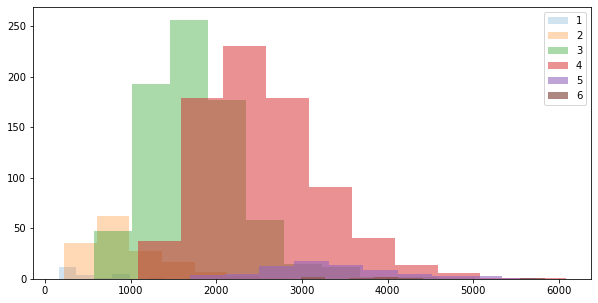

In [2295]:
plt.figure(figsize = (10,5))
plt.hist(essay_2.loc[essay_2["score"] == 1, "sen_len"], label = '1', alpha = 0.2)
plt.hist(essay_2.loc[essay_2["score"] == 2, "sen_len"], label = '2', alpha = 0.3)
plt.hist(essay_2.loc[essay_2["score"] == 3, "sen_len"], label = '3', alpha = 0.4)
plt.hist(essay_2.loc[essay_2["score"] == 4, "sen_len"], label = '4', alpha = 0.5)
plt.hist(essay_2.loc[essay_2["score"] == 5, "sen_len"], label = '5', alpha = 0.6)
plt.hist(essay_2.loc[essay_2["score"] == 6, "sen_len"], label = '6', alpha = 0.7)

plt.legend()

### 결론 1 : 일부 점수대( 5 - 6점)를 제외하고, 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 품사 태깅 및 비율 확인

가설 : 에세이에 존재하는 모든 품사들과 1)문장 갯수 or 2) 단어 갯수와의 비율을 산정한다.

적어도 한 개의 품사 비율은 점수를 예측하는데 유의미한 정보를 포함하고 있을 것이다.

#### - Boruta 알고리즘

제한된 분석 시간 하에서 유의미한 정보를 포함하고 있는 품사를 도출하기 위해 Boruta 알고리즘을 활용한다.

In [2787]:
sp = spacy.load('en_core_web_sm')

각 에세이에서 단어, 품사(대), 품사(소), 원형, 문장 성분을 추출한다.

해당 데이터를 Essay_id로 묶는다.

In [2788]:
pos_tagging = [list(map(lambda x : 
                       [essay_2.loc[i, "essay_id"], x.text, x.pos_, x.tag_, x.lemma_, x.dep_], 
                       sp(essay_2["essay"][i]))) 
              for i in range(0, len(essay_2))]

result = DataFrame(columns = ["essay_id","word","pos","tag","lemma","depend"])

for i in range(0, len(pos_tagging)):
    result = pd.concat([result, DataFrame(pos_tagging[i], columns = ["essay_id","word","pos","tag","lemma","depend"])])

result의 포함된 결과물은 다음과 같다.

essay_id : 에세이 번호

word : 단어

pos : 품사(대분류, 명사 등)

tag : 품사(소분류, 대명사 등)

lemma : 원형

depend ; 문장 성분(주어, 목적어 등)

In [2299]:
# 결과물 예시

result

,essay_id,word,pos,tag,lemma,depend
0,2978,Certain,ADJ,JJ,certain,amod
1,2978,materials,NOUN,NNS,material,nsubjpass
2,2978,being,AUX,VBG,be,auxpass
3,2978,removed,VERB,VBN,remove,advcl
4,2978,from,ADP,IN,from,prep
...,...,...,...,...,...,...
523,4777,everyone,PRON,NN,everyone,nsubj
524,4777,is,AUX,VBZ,be,ccomp
525,4777,different,ADJ,JJ,different,acomp
526,4777,then,ADV,RB,then,advmod


In [2790]:
sen_count = essay_2["essay"].apply(lambda x : len(nltk.sent_tokenize(x))).reset_index(name = "sen_count")

sen_count = pd.concat([essay_2["essay_id"], essay_2["essay"].apply(lambda x : len(nltk.sent_tokenize(x)))], axis = 1)

sen_count.columns = ["essay_id","sen_count"]

In [2791]:
len_count = result.groupby("essay_id")["lemma"].count().reset_index()

len_count.columns = ["essay_id","len_count"]

In [2792]:
## 각 품사를 총 단어 갯수로 나눔

count_result = DataFrame({"essay_id" : result["essay_id"].unique()})

for i in result["tag"].unique():

    test = result[result["tag"] == i]

    lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()
    
    count = pd.merge(lemma_count, len_count)

    count["{}_ratio".format(i)] = count["lemma"] / count["len_count"]
    
    count_result = pd.merge(count_result, count, how = "left")


In [2793]:
## NaN인 경우는 해당 품사가 없다는 의미이므로 0으로 처리해준다.

count_result = count_result.fillna(0)

In [2794]:
count_result = pd.merge(count_result, essay_2[["essay_id","score"]])

Boruta 알고리즘은 RF를 활용하여 1) 의미를 갖는 실제 변수 2) Random Shuffle 하여 의미를 가지지 않는 변수 
간의 변수 중요도를 구해 비교한다.

Random Shuffle한 변수보다 실제 변수의 변수 중요도가 낮다면, 그 변수는 예측에 도움이 되지 않는 변수로 간주할 수 있다.

In [2319]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y

X = count_result.loc[:,"JJ_ratio" : "AFX_ratio"].values
y = count_result["score"].values
y = y.ravel()


rf = RandomForestRegressor(n_jobs=-1)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

feat_selector.fit(X, y)

feat_selector.support_

feat_selector.ranking_

X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	48
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


In [2325]:
#Boruta 알고리즘 결과 유의미하다고 도출된 변수 목록

DataFrame({"col" : count_result.loc[:,"JJ_ratio" : "AFX_ratio"].columns, "importance" : feat_selector.support_})

,col,importance
0,JJ_ratio,True
1,NNS_ratio,False
2,VBG_ratio,False
3,VBN_ratio,False
4,IN_ratio,False
5,",_ratio",False
6,NN_ratio,False
7,CC_ratio,False
8,MD_ratio,False
9,RB_ratio,False


In [2326]:
print("1점 : " , count_result[count_result["score"] == 1]["JJ_ratio"].mean())
print("2점 : ", count_result[count_result["score"] == 2]["JJ_ratio"].mean())
print("3점 : ", count_result[count_result["score"] == 3]["JJ_ratio"].mean())
print("4점 : ", count_result[count_result["score"] == 4]["JJ_ratio"].mean())
print("5점 : ", count_result[count_result["score"] == 5]["JJ_ratio"].mean())
print("6점 : ", count_result[count_result["score"] == 6]["JJ_ratio"].mean())

1점 :  0.04224766668429486
2점 :  0.04488792505950676
3점 :  0.05032689470680973
4점 :  0.05362150729800799
5점 :  0.05615688012822744
6점 :  0.05636916181150158


JJ는 형용사를 뜻하는 코드로, 총 단어 갯수 중 형용사 비율이 높아질수록 고득점을 받을 수 있는 것으로 보인다.

검정이 필요하다.

In [2523]:
from itertools import permutations
a = count_result["score"].unique()
permute = list(permutations(a,2))


일부 짝에서는 CLT를 가정하기 어려울 정도로 샘플수가 작다.(점수 5의 샘플수 : 16건, 점수 6의 샘플수 : 8건)

따라서 비모수 검정법인 KS검정을 사용한다.

In [2526]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ks_2samp(count_result.loc[count_result["score"] == i[0],"JJ_ratio"], 
                              count_result.loc[count_result["score"] == i[1],"JJ_ratio"])[1])

In [2527]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

C:\Users\User\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,permute,pvalue,test
0,"(4, 1)",4.043478e-03,True
1,"(4, 2)",1.729852e-10,True
2,"(4, 5)",1.669507e-01,False
3,"(4, 3)",5.819887e-07,True
4,"(4, 6)",8.042123e-01,False
5,"(1, 4)",4.043478e-03,True
6,"(1, 2)",8.216783e-01,False
7,"(1, 5)",2.424966e-04,True
8,"(1, 3)",6.313056e-02,False
9,"(1, 6)",9.434642e-02,False


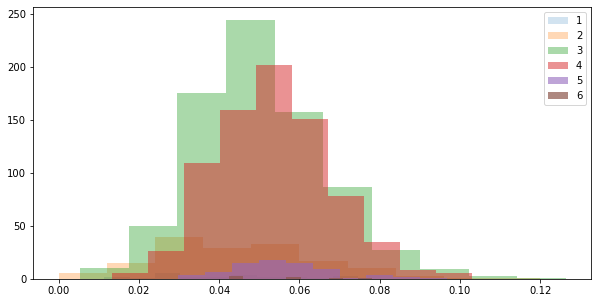

In [2528]:
plt.figure(figsize = (10,5))
plt.hist(count_result.loc[count_result["score"] == 1, "JJ_ratio"], label = '1', alpha = 0.2)
plt.hist(count_result.loc[count_result["score"] == 2, "JJ_ratio"], label = '2', alpha = 0.3)
plt.hist(count_result.loc[count_result["score"] == 3, "JJ_ratio"], label = '3', alpha = 0.4)
plt.hist(count_result.loc[count_result["score"] == 4, "JJ_ratio"], label = '4', alpha = 0.5)
plt.hist(count_result.loc[count_result["score"] == 5, "JJ_ratio"], label = '5', alpha = 0.6)
plt.hist(count_result.loc[count_result["score"] == 6, "JJ_ratio"], label = '6', alpha = 0.7)

plt.legend()

#### 결론 2 : 형용사 비율인 JJ_RATIO는 일부 짝에 대해서 유의미한것으로 나타났다. 후보 파생변수로  고려한다.

#### - 부사절 접속사(Beacuse, while,  if 등)

가설 : 에세이 1은 컴퓨터가 인류에게 도움이 되는지 아닌지 스탠스를 정해 설득문을 작성하는게 주제이다.

#### 따라서 훌륭한 논증을 펼친 에세이일수록

#### Because, While, if 등 주로 이유와 조건들을 제시하는 접속사인 부사절 접속사가 다수 포함되어 있을 것이라고 가설을 세울 수 있다.

In [2809]:
#SCONJ는 부사절 접속사를 의미한다.

result = result.reset_index(drop = True)

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2810]:
count = pd.merge(lemma_count, len_count)

count["SCONJ_noun_ratio"] = count["lemma"] / count["len_count"]

count = pd.merge(count, essay_2[["essay_id","score"]])

count = count[["essay_id","lemma","len_count","SCONJ_noun_ratio","score"]]

각 에세이별로 총 단어 갯수(len_count)와 그 중 부사절 접속사의 갯수를 비율로 산출한다(SCONJ_noun_ratio)

In [2811]:
# 부사절 / 단어 갯수 비율

print("1점 : " , count[count["score"] == 1]["SCONJ_noun_ratio"].mean())
print("2점 : ", count[count["score"] == 2]["SCONJ_noun_ratio"].mean())
print("3점 : ", count[count["score"] == 3]["SCONJ_noun_ratio"].mean())
print("4점 : ", count[count["score"] == 4]["SCONJ_noun_ratio"].mean())
print("5점 : ", count[count["score"] == 5]["SCONJ_noun_ratio"].mean())
print("6점 : ", count[count["score"] == 6]["SCONJ_noun_ratio"].mean())

1점 :  0.027968870658878486
2점 :  0.03120881610285256
3점 :  0.026820113021133973
4점 :  0.02419084570688113
5점 :  0.02118827672694383
6점 :  0.013901143568681353


점수에 대하여 부사절 접속사의 비율을 확인해봤으나 패턴을 찾기 어렵다.

#### 결론 3 : 하 / 중 / 상 점수간 부사절 접속사 / 단어 갯수 비율은 유의미한 차이가 없다.

In [2813]:
result = result.reset_index(drop = True)

lemma_reason = DataFrame({"pos" : ["SCONJ"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2814]:
count = pd.merge(lemma_count, sen_count)

count["SCONJ_ratio"] = count["lemma"] / count["sen_count"]

count = pd.merge(count, essay_2[["essay_id","score"]])

count = count[["essay_id","lemma","sen_count","SCONJ_ratio","score"]]

In [2815]:
# 부사절 / 문장 갯수 비율

print("1점 : " , count[count["score"] == 1]["SCONJ_ratio"].mean())
print("2점 : ", count[count["score"] == 2]["SCONJ_ratio"].mean())
print("3점 : ", count[count["score"] == 3]["SCONJ_ratio"].mean())
print("4점 : " , count[count["score"] == 4]["SCONJ_ratio"].mean())
print("5점 : ", count[count["score"] == 5]["SCONJ_ratio"].mean())
print("6점 : ", count[count["score"] == 6]["SCONJ_ratio"].mean())

1점 :  0.9466830065359477
2점 :  0.9834901937985103
3점 :  0.687395375221056
4점 :  0.5370784362566854
5점 :  0.45225875916280256
6점 :  0.26035538791528856


특이하게 SCONJ 비율이 낮아질수록 고득점인 패턴이 발견되었다. 검증이 필요하다.

In [2599]:
from itertools import permutations
a = count["score"].unique()
permute = list(permutations(a,2))


일부 짝에서는 CLT를 가정하기 어려울 정도로 샘플수가 작다.(점수 5의 샘플수 : 16건, 점수  6의 샘플수 : 8건)

따라서 비모수 검정법인 KS검정을 사용한다.

In [2600]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ks_2samp(count.loc[count["score"] == i[0],"SCONJ_ratio"], 
                              count.loc[count["score"] == i[1],"SCONJ_ratio"])[1])

In [2601]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(4, 1)",2.125112e-03,True
1,"(4, 2)",2.763778e-11,True
2,"(4, 5)",1.297167e-01,False
3,"(4, 3)",3.912799e-08,True
4,"(4, 6)",3.568921e-03,True
5,"(1, 4)",2.125112e-03,True
6,"(1, 2)",8.348925e-01,False
7,"(1, 5)",2.749719e-04,True
8,"(1, 3)",4.317590e-02,True
9,"(1, 6)",1.752193e-03,True


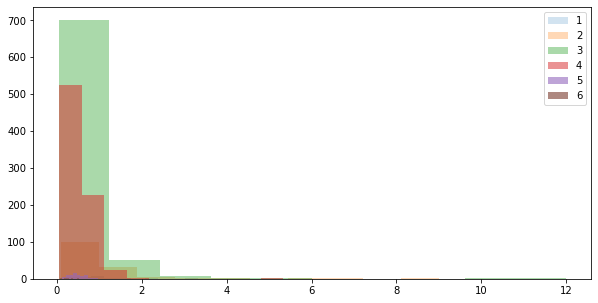

In [2602]:
plt.figure(figsize = (10,5))
plt.hist(count.loc[count["score"] == 1, "SCONJ_ratio"], label = '1', alpha = 0.2)
plt.hist(count.loc[count["score"] == 2, "SCONJ_ratio"], label = '2', alpha = 0.3)
plt.hist(count.loc[count["score"] == 3, "SCONJ_ratio"], label = '3', alpha = 0.4)
plt.hist(count.loc[count["score"] == 4, "SCONJ_ratio"], label = '4', alpha = 0.5)
plt.hist(count.loc[count["score"] == 5, "SCONJ_ratio"], label = '5', alpha = 0.6)
plt.hist(count.loc[count["score"] == 6, "SCONJ_ratio"], label = '6', alpha = 0.7)

plt.legend()

#### 결론 3 : 일부 짝에 한하여 부사절 접속사의 문장 갯수에 대한 비율에 유의한 차이가 있는 것으로 도출되었다. 후보 변수로 고려한다.

### (4) Argument Feature

가설 : 부사절 접속사 전체가 아닌, 몇개의 접속사 (if, since, when, as, because, unless)를 추려 단어 갯수 / 문장 갯수와의 

비율을 산정하면 좀 더 뚜렷한 차이가 나타날 수 있다.

#### - 선정된 접속사 / 문장 갯수 비율(상위권)

In [2584]:
result = result.reset_index(drop = True)

lemma_reason = DataFrame({"lemma" : ["if","since","when","as","because","unless"]})

test = pd.merge(lemma_reason, result, how = "left")

lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()

In [2585]:
count_2 = pd.merge(lemma_count, sen_count)

count_2["lemma_sen_ratio"] = count_2["lemma"] / count_2["sen_count"]

count_2 = pd.merge(count_2, essay_2[["essay_id","score"]])

count_2 = count_2[["essay_id","lemma","sen_count","lemma_sen_ratio","score"]]

In [2586]:
# 조건&이유 접속사 / 문장 갯수 비율

print("1점 : " , count_2[count_2["score"] == 1]["lemma_sen_ratio"].mean())
print("2점 : ", count_2[count_2["score"] == 2]["lemma_sen_ratio"].mean())
print("3점 : ", count_2[count_2["score"] == 3]["lemma_sen_ratio"].mean())
print("4점 : " , count_2[count_2["score"] == 4]["lemma_sen_ratio"].mean())
print("5점 : ", count_2[count_2["score"] == 5]["lemma_sen_ratio"].mean())
print("6점 : ", count_2[count_2["score"] == 6]["lemma_sen_ratio"].mean())

1점 :  0.9187235678585159
2점 :  0.7470722208596556
3점 :  0.5139181538785116
4점 :  0.41325854771073955
5점 :  0.38797009316857933
6점 :  0.31429537609664965


In [2587]:
from itertools import permutations
a = count_2["score"].unique()
permute = list(permutations(a,2))


일부 짝에서는 CLT를 가정하기 어려울 정도로 샘플수가 작다.(점수 5 : 16건, 점수  6 : 8건)

따라서 비모수 검정법인 KS검정을 사용한다.

In [2588]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ks_2samp(count_2.loc[count_2["score"] == i[0],"lemma_sen_ratio"], 
                              count_2.loc[count_2["score"] == i[1],"lemma_sen_ratio"])[1])

In [2589]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(4, 1)",1.624122e-04,True
1,"(4, 2)",1.404140e-08,True
2,"(4, 5)",9.403413e-01,False
3,"(4, 3)",5.107056e-08,True
4,"(4, 6)",1.849716e-01,False
5,"(1, 4)",1.624122e-04,True
6,"(1, 2)",3.884542e-02,True
7,"(1, 5)",6.247140e-04,True
8,"(1, 3)",1.082360e-03,True
9,"(1, 6)",2.432795e-03,True


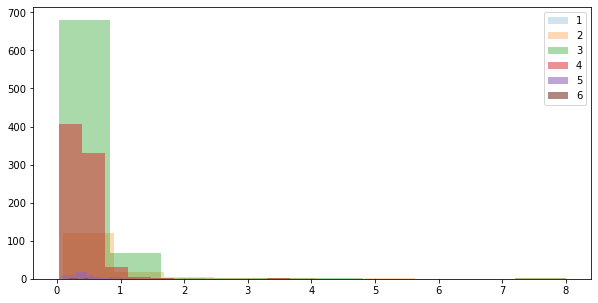

In [2590]:
plt.figure(figsize = (10,5))
plt.hist(count_2.loc[count_2["score"] == 1, "lemma_sen_ratio"], label = '1', alpha = 0.2)
plt.hist(count_2.loc[count_2["score"] == 2, "lemma_sen_ratio"], label = '2', alpha = 0.3)
plt.hist(count_2.loc[count_2["score"] == 3, "lemma_sen_ratio"], label = '3', alpha = 0.4)
plt.hist(count_2.loc[count_2["score"] == 4, "lemma_sen_ratio"], label = '4', alpha = 0.5)
plt.hist(count_2.loc[count_2["score"] == 5, "lemma_sen_ratio"], label = '5', alpha = 0.6)
plt.hist(count_2.loc[count_2["score"] == 6, "lemma_sen_ratio"], label = '6', alpha = 0.7)

plt.legend()

검정 결과 일부 짝에서 유의미한 차이가 있는 것으로 나타났다.

이는 바로 앞에서 진행한 부사절 접속사(SCONJ)와 동일한 이유를 따르는 것으로 보인다.

즉, SCONJ에 이미 "if","since","when","as","because","unless" 등이 포함되어 있기 때문에

그 범주에서 6개를 추려서 다시 진행해도 비슷한 결과가 도출됬다고 볼 수 있다.

#### 결론 4 : 일부 짝에 한하여 6개 접속사의 문장 갯수에 대한 비율에 유의한 차이가 있는 것으로 도출되었다. 후보 변수로 추가한다.

EDA 결과 문장 길이, 형용사 비율(JJ_ratio), 부사절 접속사 비율(SCONJ_ratio), 6개 특정 접속사 비율(lemma_noun_ratio)가 

써볼법한 추가 파생변수로 도출되었다.  동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [2796]:
encoding_result = DataFrame()

for i in essay_2["essay_id"].unique():
    text = essay_2.loc[essay_2["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_2, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")


In [2817]:
train_df = pd.merge(train_df, count_result[["essay_id","JJ_ratio"]])

In [2818]:
train_df = pd.merge(train_df, count[["essay_id","SCONJ_ratio"]])

In [2819]:
train_df = pd.merge(train_df, count_2[["essay_id","lemma_sen_ratio"]])

In [2835]:
# Default



columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3333333333333333

In [2825]:
# JJ_ratio포함

columns = [i for i in range(0, 39755)]

columns.append("JJ_ratio")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3581081081081081

In [2826]:
# SCONJ_ratio 포함

columns = [i for i in range(0, 39755)]

columns.append("SCONJ_ratio")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3333333333333333

In [2827]:
# lemma_sen_ratio 포함

columns = [i for i in range(0, 39755)]

columns.extend(["lemma_sen_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3333333333333333

In [2828]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3310810810810811

In [2829]:
# sen_len, JJ_ratio포함(Best)

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len","JJ_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.30180180180180183

In [2830]:
# sen_len, SCONJ_ratio포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len","SCONJ_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.30180180180180183

In [2833]:
# sen_len, JJ_ratio, SCONJ_ratio, lemma_sen_ratio 

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len","JJ_ratio","SCONJ_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.3153153153153153

#### 변수중요도

가장 성능이 좋았던 sen_len, JJ_ratio 포함 모델의 변수 중요도는 아래와 같다.

In [2627]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)

,col,importance
39755,sen_len,0.511178
39756,JJ_ratio,0.013626
14845,14845,0.009910
292,292,0.005242
6189,6189,0.005135
...,...,...
13789,13789,0.000000
13790,13790,0.000000
13791,13791,0.000000
13792,13792,0.000000


# 2) Essay_3

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [2628]:
essay_3 = essay[essay["essay_set"] == 3].reset_index(drop = True)

In [2629]:
essay_3["sen_len"] = essay_3["essay"].apply(lambda x : len(x))

#### - 점수별 분포

<AxesSubplot:>

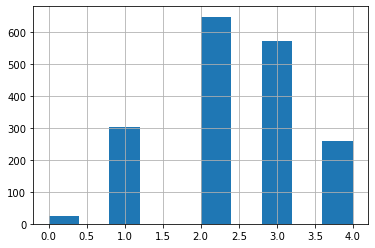

In [2630]:
essay_3["score"].hist()

### (1) 점수와 문장 길이

In [2631]:
essay_3.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,0,186.250000
1,1,319.215232
2,2,535.047766
3,3,830.923077
4,4,1201.186047


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

실제로 그런지 검정이 필요하다.

In [2632]:
model = ols('sen_len ~ score',essay_3).fit()
anova_result = anova_lm(model)

### - 정규성 검정

In [2633]:
essay_3["resid"] = model.resid

In [2634]:
essay_3["fitted"] = model.fittedvalues

In [2635]:
essay_3.groupby(["score"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score
0      (0.9198850989341736, 0.05806826427578926)
1     (0.883543074131012, 2.106806584387371e-14)
2    (0.9793874025344849, 6.391103823943922e-08)
3    (0.9836322665214539, 4.962557795806788e-06)
4    (0.9372871518135071, 5.018920390398307e-09)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

### - QQPLOT

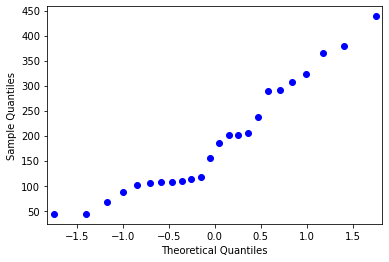

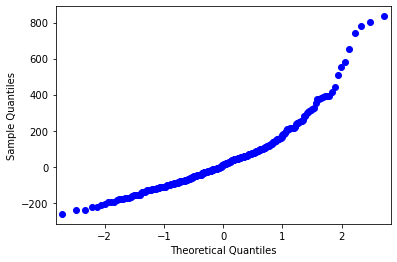

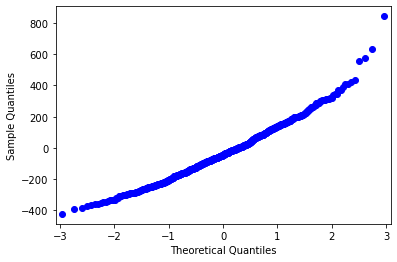

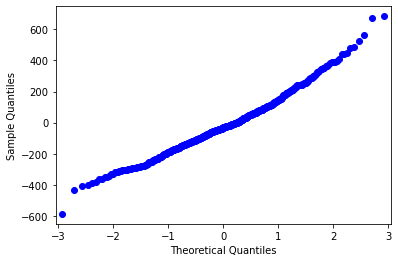

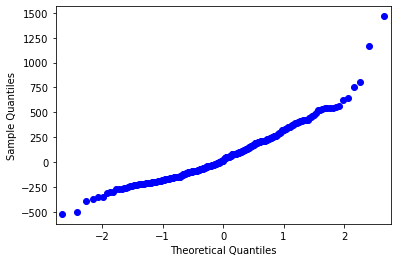

In [2636]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_3.groupby(["score"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규성을 만족하지 못하고 있다.

ANOVA는 사용할 수가 없다.

#### - T-TEST

CLT에 의해 정당화 가능한 평균검정법인 T-TEST로 각 짝에 대하여 검정한다.

In [2637]:
from itertools import permutations
a = essay_3["score"].unique()
permute = list(permutations(a,2))


In [2638]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_3.loc[essay_3["score"] == i[0],"sen_len"], 
                              essay_3.loc[essay_3["score"] == i[1],"sen_len"],equal_var = False)[1])

In [2639]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(2, 3)",5.825652e-144,True
1,"(2, 1)",1.736877e-57,True
2,"(2, 4)",1.333833e-124,True
3,"(2, 0)",3.595388e-14,True
4,"(3, 2)",5.825652e-144,True
5,"(3, 1)",1.990888e-179,True
6,"(3, 4)",3.038436e-63,True
7,"(3, 0)",2.661290e-21,True
8,"(1, 2)",1.736877e-57,True
9,"(1, 3)",1.990888e-179,True


모든 조합(짝)에서 각 Score별로 평균에는 유의미한 차이가 존재한다.

### 결론 1 : 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 평가기준과 정답간 유사도

가설 : 평가 기준을 벡터화하여 Essay와의 일치도를 본다. 점수가 높을수록 평가 기준과의 코사인 유사도는 높을 것이라 가설을 세울 수 있다.

#### - 평가기준 벡터화

In [2640]:
criterion = 'The response should describe a mood of gratitude, love, similar appreciative mood. The response may include, but is not limited to: the author says he is “eternally grateful” to his parents for instilling in him a love of cooking. He also credits them for his appreciation of Cuban music "which I adore to this day." In general he notes their having made an inviting home filled with "endless celebrations" out of "modest" means. the author credits his parents for instilling in him a great sense of "family" due to the "environment" they created. This sense of family extended to everyone in a time when the larger world was uninviting.the author mentions his family’s generosity in allowing others to stay with them and notes its reciprocal nature the author recognizes that his parents came to America "selflessly" in order to "give their children a better life." He details their challenges and obstacles and observes that they "endured." "I will always be grateful to my parents for their love and sacrifice. I’ve often told them that what they did was a much morecourageous thing than I could have ever done." He mentions his admiration andhaving thanked them yet admits that he has, "no way to express my gratitude." "I will never forget that house or its gracious neighborhood or the many things I learned there about how to love. I will never forget how my parents turned this simple house into a home"'

In [2641]:
pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion)))

In [2642]:
result_criterion = DataFrame(columns = ["lemma"])

for i in range(0, len(pos_tagging)):
    result_criterion = pd.concat([result_criterion, 
                                  DataFrame(pos_tagging[i], 
                                            columns = ["lemma"])])

In [2643]:
morphs = list(result_criterion["lemma"])

In [2644]:
morphsVectored = list()

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored.append(temporailyList)


In [2645]:
vector_shell = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

In [2646]:
vector_shell[np.reshape(np.array(morphsVectored),[-1])] = 1

In [2647]:
cos_simil = list()

for i in essay_3["essay_id"].unique():
    text = essay_3.loc[essay_3["essay_id"] == i, "essay"]
    
    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))
    
    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])
        
    morphs = list(result_text["lemma"])
    
    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)
        
    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])
    
    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1
    
    simil_result = vector_shell.dot(vector_shell_text) / (np.linalg.norm(vector_shell) * np.linalg.norm(vector_shell_text))
    
    cos_simil.append(simil_result)

In [2648]:
essay_3["cos_simil"] = cos_simil

In [2649]:
essay_3.groupby("score")["cos_simil"].apply(lambda x : np.mean(x))

score
0    0.241702
1    0.294411
2    0.360438
3    0.400474
4    0.418406
Name: cos_simil, dtype: float64

점수가 올라갈수록 발제문과 코사인 유사도가 높아지는 양상을 확인 가능하다.

실제로 각 점수별로 차이가 있는지 검정이 필요하다.

#### T-TEST

In [2650]:
from itertools import permutations
a = essay_3["score"].unique()
permute = list(permutations(a,2))


In [2651]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_3.loc[essay_3["score"] == i[0],"cos_simil"], 
                              essay_3.loc[essay_3["score"] == i[1],"cos_simil"],equal_var = False)[1])

In [2652]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(2, 3)",1.368695e-36,True
1,"(2, 1)",7.033174e-60,True
2,"(2, 4)",8.550282e-45,True
3,"(2, 0)",2.165535e-11,True
4,"(3, 2)",1.368695e-36,True
5,"(3, 1)",1.290235e-120,True
6,"(3, 4)",1.680326e-06,True
7,"(3, 0)",3.909627e-14,True
8,"(1, 2)",7.033174e-60,True
9,"(1, 3)",1.290235e-120,True


모든 점수 짝에서 차이가 유의미한 것으로 나타났다.

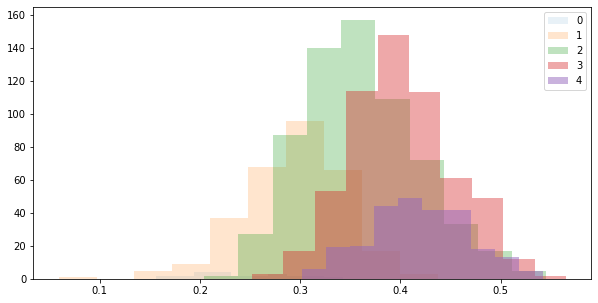

In [2653]:
plt.figure(figsize = (10,5))
plt.hist(essay_3.loc[essay_3["score"] == 0, "cos_simil"], label = '0', alpha = 0.1)
plt.hist(essay_3.loc[essay_3["score"] == 1, "cos_simil"], label = '1', alpha = 0.2)
plt.hist(essay_3.loc[essay_3["score"] == 2, "cos_simil"], label = '2', alpha = 0.3)
plt.hist(essay_3.loc[essay_3["score"] == 3, "cos_simil"], label = '3', alpha = 0.4)
plt.hist(essay_3.loc[essay_3["score"] == 4, "cos_simil"], label = '4', alpha = 0.5)

plt.legend()

코사인 유사도의 분포의 평균이 명확하게 차이나는 것으로 이 결과를 뒷받침 할 수 있다.

### 결론 2 : 점수가 높아질수록 발제문과의 코사인 유사도가 유의미하게 높아진다.

EDA 결과 문장 길이, 코사인 유사도가 

써볼법한 추가 파생변수로 도출되었다.  동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [2654]:
encoding_result = DataFrame()

for i in essay_3["essay_id"].unique():
    text = essay_3.loc[essay_3["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_3, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")

In [2655]:
# Default



columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.4358407079646018

In [2656]:
# cos_simil 포함

columns = [i for i in range(0, 39755)]

columns.append("cos_simil")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.4269911504424779

In [2659]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.append("sen_len")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.336283185840708

In [2658]:
# cos_simil, sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["cos_simil", "sen_len"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.35398230088495575

#### 변수중요도

가장 성능이 좋았던 sen_len 포함 모델의 변수 중요도는 아래와 같다.

In [2660]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)

,col,importance
39755,sen_len,0.722088
3639,3639,0.003268
14552,14552,0.002781
21264,21264,0.002777
24594,24594,0.002667
...,...,...
13698,13698,0.000000
13699,13699,0.000000
13700,13700,0.000000
13701,13701,0.000000


# 4) essay_4

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [2661]:
essay_4 = essay[essay["essay_set"] == 4].reset_index(drop = True)

In [2662]:
essay_4["sen_len"] = essay_4["essay"].apply(lambda x : len(x))

#### - 점수별 분포

<AxesSubplot:>

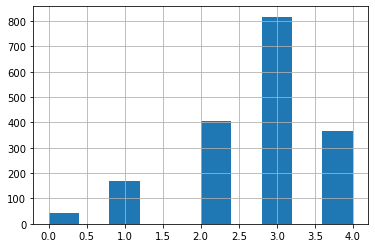

In [2663]:
essay_4["score"].hist()

### (1) 점수와 문장 길이

In [2664]:
essay_4.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,0,353.772727
1,1,518.568862
2,2,698.276543
3,3,936.916769
4,4,1235.885559


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

실제로 그런지 검정이 필요하다.

In [2665]:
model = ols('sen_len ~ score',essay_4).fit()
anova_result = anova_lm(model)

### - 정규성 검정

In [2666]:
essay_4["resid"] = model.resid

In [2667]:
essay_4["fitted"] = model.fittedvalues

In [2668]:
essay_4.groupby(["score"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score
0      (0.9075021743774414, 0.001865890808403492)
1    (0.9644820690155029, 0.00028531477437354624)
2     (0.9638830423355103, 1.954551187566267e-08)
3    (0.9793832898139954, 2.4912234497520558e-09)
4     (0.9322113394737244, 7.235198551391875e-12)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

### - QQPLOT

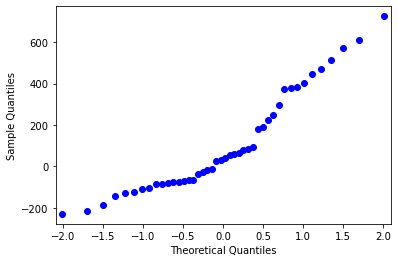

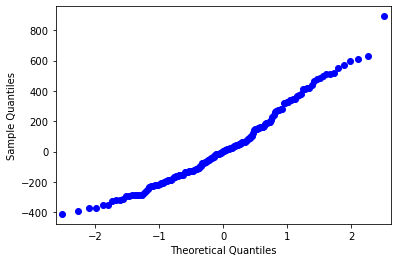

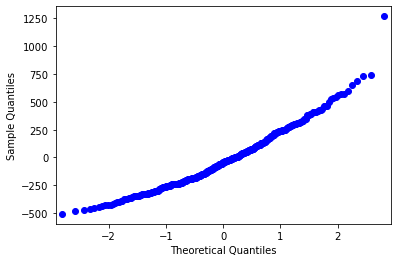

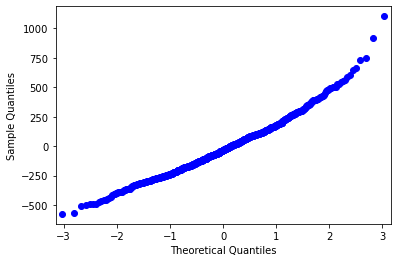

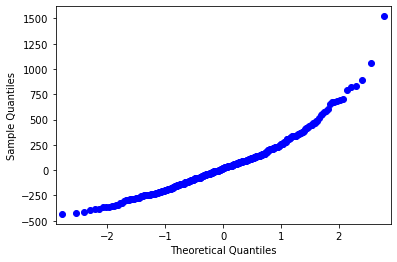

In [2669]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_4.groupby(["score"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규성을 만족하지 못하고 있다.

ANOVA는 사용할 수가 없다.

#### - T-TEST

CLT에 의해 정당화 가능한 평균검정법인 T-TEST로 각 짝에 대하여 검정한다.

In [2670]:
from itertools import permutations
a = essay_4["score"].unique()
permute = list(permutations(a,2))


In [2671]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_4.loc[essay_4["score"] == i[0],"sen_len"], 
                              essay_4.loc[essay_4["score"] == i[1],"sen_len"],equal_var = False)[1])

In [2672]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(2, 3)",1.824908e-51,True
1,"(2, 4)",1.760378e-128,True
2,"(2, 1)",1.356083e-13,True
3,"(2, 0)",5.138368e-12,True
4,"(3, 2)",1.824908e-51,True
5,"(3, 4)",1.874701e-66,True
6,"(3, 1)",4.829193e-51,True
7,"(3, 0)",5.431538e-20,True
8,"(4, 2)",1.760378e-128,True
9,"(4, 3)",1.874701e-66,True


모든 조합(짝)에서 각 Score별로 평균에는 유의미한 차이가 존재한다.

### 결론 1 : 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 평가기준과 정답간 유사도

가설 : 평가 기준을 벡터화하여 Essay와의 일치도를 본다. 점수가 높을수록 평가 기준과의 코사인 유사도는 높을 것이라 가설을 세울 수 있다.

#### - 평가기준 벡터화

In [2673]:
criterion = 'The obstacles to dirigible docking include Building a mast on top of the building Meeting with engineers and dirigible engineers Transmitting the stress of the dirigible all the way down the building; the frame had to be shored up to the tune of $60,000 Housing the winches and other docking equipment Dealing with flammable gases Handling the violent air currents at the top of the building Confronting laws banning airships from the area Getting close enough to the building without puncturing'

In [2674]:
pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion)))

In [2675]:
result_criterion = DataFrame(columns = ["lemma"])

for i in range(0, len(pos_tagging)):
    result_criterion = pd.concat([result_criterion, 
                                  DataFrame(pos_tagging[i], 
                                            columns = ["lemma"])])

In [2676]:
morphs = list(result_criterion["lemma"])

In [2677]:
morphsVectored_criterion = list()

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored_criterion.append(temporailyList)


In [2678]:
vector_shell = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

In [2679]:
vector_shell[np.reshape(np.array(morphsVectored_criterion),[-1])] = 1

In [2680]:
cos_simil = list()

for i in essay_4["essay_id"].unique():
    text = essay_4.loc[essay_4["essay_id"] == i, "essay"]
    
    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))
    
    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])
        
    morphs = list(result_text["lemma"])
    
    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)
        
    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])
    
    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1
    
    simil_result = vector_shell.dot(vector_shell_text) / (np.linalg.norm(vector_shell) * np.linalg.norm(vector_shell_text))
    
    cos_simil.append(simil_result)

In [2681]:
essay_4["cos_simil"] = cos_simil

In [2682]:
essay_4.groupby("score")["cos_simil"].apply(lambda x : np.mean(x))

score
0    0.227857
1    0.263604
2    0.282847
3    0.303765
4    0.314027
Name: cos_simil, dtype: float64

점수가 올라갈수록 발제문과 코사인 유사도가 높아지는 양상을 확인 가능하다.

실제로 각 점수별로 차이가 있는지 검정이 필요하다.

#### T-TEST

In [2683]:
from itertools import permutations
a = essay_4["score"].unique()
permute = list(permutations(a,2))


In [2684]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_4.loc[essay_4["score"] == i[0],"cos_simil"], 
                              essay_4.loc[essay_4["score"] == i[1],"cos_simil"],equal_var = False)[1])

In [2685]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(2, 3)",1.449157e-15,True
1,"(2, 4)",1.210119e-25,True
2,"(2, 1)",1.748514e-06,True
3,"(2, 0)",3.579715e-10,True
4,"(3, 2)",1.449157e-15,True
5,"(3, 4)",1.562498e-05,True
6,"(3, 1)",2.032946e-23,True
7,"(3, 0)",1.746900e-14,True
8,"(4, 2)",1.210119e-25,True
9,"(4, 3)",1.562498e-05,True


모든 점수 짝에서 차이가 유의미한 것으로 나타났다.

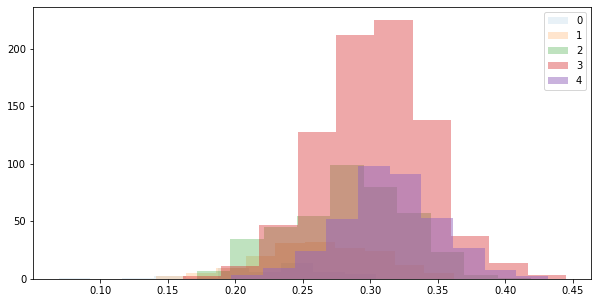

In [2686]:
plt.figure(figsize = (10,5))
plt.hist(essay_4.loc[essay_4["score"] == 0, "cos_simil"], label = '0', alpha = 0.1)
plt.hist(essay_4.loc[essay_4["score"] == 1, "cos_simil"], label = '1', alpha = 0.2)
plt.hist(essay_4.loc[essay_4["score"] == 2, "cos_simil"], label = '2', alpha = 0.3)
plt.hist(essay_4.loc[essay_4["score"] == 3, "cos_simil"], label = '3', alpha = 0.4)
plt.hist(essay_4.loc[essay_4["score"] == 4, "cos_simil"], label = '4', alpha = 0.5)

plt.legend()

코사인 유사도의 분포의 평균이 차이는 있지만, 그 차이는 essay_3만큼 극명하진 않다.

### 결론 2 : 점수가 높아질수록 발제문과의 코사인 유사도가 유의미하게 높아진다.

EDA 결과 문장 길이, 코사인 유사도가 

써볼법한 추가 파생변수로 도출되었다.  동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [2687]:
encoding_result = DataFrame()

for i in essay_4["essay_id"].unique():
    text = essay_4.loc[essay_4["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_4, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")

In [2692]:
# Default



columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.39555555555555555

In [2693]:
# cos_simil 포함

columns = [i for i in range(0, 39755)]

columns.append("cos_simil")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.40444444444444444

In [2694]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.append("sen_len")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.33555555555555555

In [2698]:
# cos_simil, sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["cos_simil", "sen_len"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

0.33555555555555555

#### 변수중요도

가장 성능이 좋았던 cos_simil, sen_len 포함 모델의 변수 중요도는 아래와 같다.

In [2700]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)[0:10]

,col,importance
39756,sen_len,0.495542
38914,38914,0.057022
14460,14460,0.031642
20283,20283,0.027931
21293,21293,0.026234
39755,cos_simil,0.025063
17655,17655,0.011571
14314,14314,0.007262
16669,16669,0.004394
37518,37518,0.004316


# 4) essay_5

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [1889]:
essay_5 = essay[essay["essay_set"] == 5].reset_index(drop = True)

In [1890]:
essay_5["sen_len"] = essay_5["essay"].apply(lambda x : len(x))

#### - 점수별 분포

<AxesSubplot:>

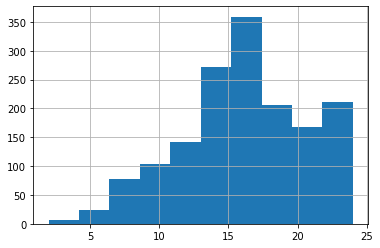

In [1891]:
essay_5["score"].hist()

### (1) 점수와 문장 길이

In [1892]:
essay_5.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,2,66.000000
1,3,23.000000
2,4,255.250000
3,5,166.000000
4,6,299.900000
5,7,346.928571
6,8,366.180000
7,9,468.612245
8,10,544.363636
9,11,621.446429


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

실제로 그런지 검정이 필요하다.

In [1893]:
essay_5.loc[essay_5["score"] < 6,"score_new"] = 0

In [1894]:
essay_5.loc[(essay_5["score"] >= 6) & (essay_5["score"] < 11),"score_new"] = 1

In [1895]:
essay_5.loc[(essay_5["score"] >= 11) & (essay_5["score"] < 15),"score_new"] = 2

In [1896]:
essay_5.loc[essay_5["score"] >= 15,"score_new"] = 3

1 ~ 12점 척도인 점수를 0 ~ 3점 척도로 변환

1, 2, 3, 4, 5 -> 0

6, 7, 8, 9, 10-> 1

11, 12, 13, 14, 15 -> 2

16 ~ 24 ~ -> 3

In [1897]:
## 고득점 사례

essay_5[essay_5["score_new"] == 1]

,essay_id,essay_set,essay,score,sen_len,score_new
9,17844,5,I think patience is a time when you have to be...,10,429,1.0
25,17862,5,Patients is verey important. But I m not verey...,9,519,1.0
26,17863,5,Patience is when you can take your time at som...,6,276,1.0
27,17864,5,When I was patient. Was when I go down the riv...,10,481,1.0
39,17878,5,Patience. Being patient means that you needs t...,10,692,1.0
...,...,...,...,...,...,...
1507,19497,5,I was patient when my mom when to the doctors ...,9,132,1.0
1510,19500,5,A time when my CAPS1 was patient is to day las...,9,673,1.0
1552,19544,5,At the CAPS1’s office. I had an CAPS2 appointm...,9,514,1.0
1557,19549,5,When I was and the NUM1 grade and I had to put...,8,518,1.0


In [1898]:
## 저득점 사례

essay_5[essay_5["score_new"] == 3]

,essay_id,essay_set,essay,score,sen_len,score_new
0,17834,5,Patience is when your waiting .I was patience ...,15,488,3.0
2,17837,5,One day I was at basketball practice and I was...,15,766,3.0
3,17838,5,I going to write about a time when I went to t...,17,1122,3.0
5,17840,5,There was a girl name PERSON1. She loved spend...,23,1873,3.0
6,17841,5,Un Patience CAPS1. My name is CAPS2 and I ha...,16,810,3.0
...,...,...,...,...,...,...
1563,19557,5,Awhile back my friends and I made a CAPS2 game...,24,1518,3.0
1565,19559,5,A patent person in my life is my mom. Aicason ...,16,1169,3.0
1566,19561,5,A time when someone else I know was patient wa...,19,863,3.0
1567,19562,5,I hate weddings. I love when people get marrie...,22,1560,3.0


In [1899]:
model = ols('sen_len ~ score_new',essay_5).fit()
anova_result = anova_lm(model)

### - 정규성 검정

In [1900]:
essay_5["resid"] = model.resid

In [1901]:
essay_5["fitted"] = model.fittedvalues

In [1902]:
essay_5.groupby(["score_new"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score_new
0.0       (0.9039049744606018, 0.24169045686721802)
1.0      (0.8726758360862732, 5.32403504963086e-12)
2.0    (0.9048911333084106, 1.5837937244241734e-13)
3.0    (0.9365941286087036, 1.6737865601278402e-20)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

### - QQPLOT

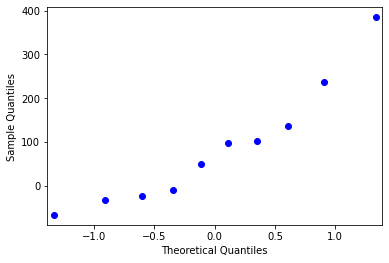

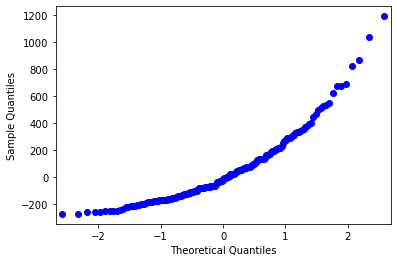

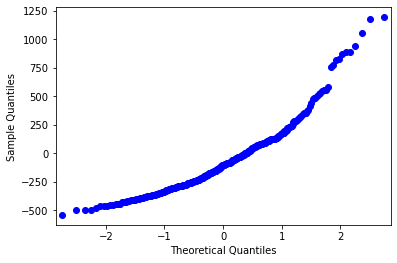

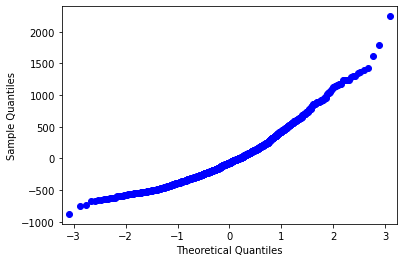

In [1903]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_5.groupby(["score_new"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규성을 만족하지 못하고 있다.

ANOVA는 사용할 수가 없다.

#### - T-TEST

CLT에 의해 정당화 가능한 평균검정법인 T-TEST로 각 짝에 대하여 검정한다.

In [1904]:
from itertools import permutations
a = essay_5["score_new"].unique()
permute = list(permutations(a,2))


In [1905]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_5.loc[essay_5["score_new"] == i[0],"sen_len"], 
                              essay_5.loc[essay_5["score_new"] == i[1],"sen_len"],equal_var = False)[1])

In [1906]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(3.0, 2.0)",1.210089e-57,True
1,"(3.0, 1.0)",4.004382e-91,True
2,"(3.0, 0.0)",2.943986e-09,True
3,"(2.0, 3.0)",1.210089e-57,True
4,"(2.0, 1.0)",6.660722e-15,True
5,"(2.0, 0.0)",7.915888e-07,True
6,"(1.0, 3.0)",4.004382e-91,True
7,"(1.0, 2.0)",6.660722e-15,True
8,"(1.0, 0.0)",1.778427e-04,True
9,"(0.0, 3.0)",2.943986e-09,True


모든 조합(짝)에서 각 Score별로 평균에는 유의미한 차이가 존재한다.

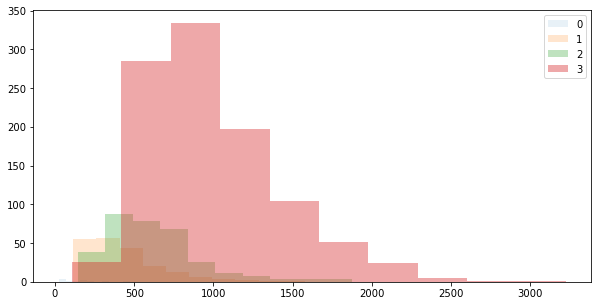

In [1907]:
plt.figure(figsize = (10,5))
plt.hist(essay_5.loc[essay_5["score_new"] == 0, "sen_len"], label = '0', alpha = 0.1)
plt.hist(essay_5.loc[essay_5["score_new"] == 1, "sen_len"], label = '1', alpha = 0.2)
plt.hist(essay_5.loc[essay_5["score_new"] == 2, "sen_len"], label = '2', alpha = 0.3)
plt.hist(essay_5.loc[essay_5["score_new"] == 3, "sen_len"], label = '3', alpha = 0.4)

plt.legend()

### 결론 1 : 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 발제문과 정답간 유사도

가설 : 발제문을 벡터화하여 Essay와의 일치도를 본다. 점수가 높을수록 평가 기준과의 코사인 유사도는 높을 것이라 가설을 세울 수 있다.

#### - 평가기준 벡터화

Essay 5의 수험자는 발제 세 개중 하나를 선택해서 시험을 볼 수 있다.

따라서 발제문도 대 발제문(Criterion) + (소발제문1, 소발제문2, 소발제문 3) 각각 세개로 나누어 코사인 유사도를 구한 후

가장 높은 점수를 보이는 코사인 유사도를 최종 유사도로 선정한다.

In [2094]:
criterion = 'Being Patient Means that you are understanding and tolerant. A patient Person experiences difficulties without complaining.'

In [2095]:
criterion_1 = criterion + ' write a story about a time when you were patient'
criterion_2 = criterion + ' write a story about a time when someone you know was patient'
criterion_3 = criterion + ' write a story in your own way about patience'

In [2096]:
pos_tagging_1 = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion_1)))

pos_tagging_2 = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion_2)))

pos_tagging_3 = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion_3)))

In [2097]:
result_criterion_1 = DataFrame(columns = ["lemma"])
result_criterion_2 = DataFrame(columns = ["lemma"])
result_criterion_3 = DataFrame(columns = ["lemma"])

for i in range(0, len(pos_tagging_1)):
    result_criterion_1 = pd.concat([result_criterion_1, 
                                  DataFrame(pos_tagging_1[i], 
                                            columns = ["lemma"])])
for i in range(0, len(pos_tagging_2)):
    result_criterion_2 = pd.concat([result_criterion_2, 
                                  DataFrame(pos_tagging_2[i], 
                                            columns = ["lemma"])])
    
for i in range(0, len(pos_tagging_3)):
    result_criterion_3 = pd.concat([result_criterion_3, 
                                  DataFrame(pos_tagging_3[i], 
                                            columns = ["lemma"])])

In [2098]:
morphs_1 = list(result_criterion_1["lemma"])
morphs_2 = list(result_criterion_2["lemma"])
morphs_3 = list(result_criterion_3["lemma"])

In [2099]:
morphsVectored_criterion_1 = list()
morphsVectored_criterion_2 = list()
morphsVectored_criterion_3 = list()

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs_1:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored_criterion_1.append(temporailyList)

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs_2:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored_criterion_2.append(temporailyList)
    

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs_3:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored_criterion_3.append(temporailyList)

In [2100]:
vector_shell = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

In [2101]:
vector_shell_1 = vector_shell.copy()
vector_shell_2 = vector_shell.copy()
vector_shell_3 = vector_shell.copy()

In [2102]:
vector_shell_1[np.reshape(np.array(morphsVectored_criterion_1),[-1])] = 1
vector_shell_2[np.reshape(np.array(morphsVectored_criterion_2),[-1])] = 1
vector_shell_3[np.reshape(np.array(morphsVectored_criterion_3),[-1])] = 1

In [1917]:
# 저득점 사례

essay_5.loc[9, "essay"]

'I think patience is a time when you have to be calm. It is also a time of wateing. For some people being patient is extremely hard. But for me it’s easy. At times I can be inpatient, but everyone can be. Being patient is kinda new racking, but I manage. A lot of times I get mad if I have to be too patient. I think PERCENT1 of people in the world don’t like to be patient. with patience comes a reward is you are really patient!'

In [2688]:
# 고득점 사례

essay_5.loc[3, "essay"]

'I going to write about a time when I went to the ORGANIZATION1 fair, we had fun, we saw a ride we wanted to get on, so we got in line. Suddenly, we noticed that we were at the end of the line. So my mother said.” CAPS1 get on another ride then”. We already tried the other rides,” my father said. So we stayed at the end of the line until it was our turn, and said that was the last ride, soon there were people behind us complaining, their younger children was getting mad, and parents was hollering. We just stood there, and kept being patient. That didn’t desterb us. since we were raised to be patient, and wait our turn at things. I feel being patient is very important, because if you act up in line, you might make people think they’re holding you up, but it’s the line moving slow. Advice: when you are waiting at the end of the line, don’t shout, scream, holler, or yell at anyone, it only creates trouble. Just don’t think about all of the people ahead of you, talk to someone, just take y

In [2103]:
cos_simil_1 = list()
cos_simil_2 = list()
cos_simil_3 = list()

for i in essay_5["essay_id"].unique():
    text = essay_5.loc[essay_5["essay_id"] == i, "essay"]
    
    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))
    
    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])
        
    morphs = list(result_text["lemma"])
    
    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)
        
    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])
    
    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1
    
    simil_result_1 = vector_shell_text.dot(vector_shell_1) / (np.linalg.norm(vector_shell_text) * np.linalg.norm(vector_shell_1))
    
    simil_result_2 = vector_shell_text.dot(vector_shell_2) / (np.linalg.norm(vector_shell_text) * np.linalg.norm(vector_shell_2))
    
    simil_result_3 = vector_shell_text.dot(vector_shell_3) / (np.linalg.norm(vector_shell_text) * np.linalg.norm(vector_shell_3))
    
    cos_simil_1.append(simil_result_1)
    cos_simil_2.append(simil_result_2)
    cos_simil_3.append(simil_result_3)

In [2104]:
essay_5["cos_simil_1"] = cos_simil_1
essay_5["cos_simil_2"] = cos_simil_2
essay_5["cos_simil_3"] = cos_simil_3

In [2105]:
essay_5["cos_simil"] = essay_5.apply(lambda x : np.max(x[["cos_simil_1","cos_simil_2","cos_simil_3"]]), axis = 1)

In [2106]:
essay_5.groupby("score_new")["cos_simil"].apply(lambda x : np.mean(x))

score_new
0.0    0.284520
1.0    0.285259
2.0    0.268182
3.0    0.239901
Name: cos_simil, dtype: float64

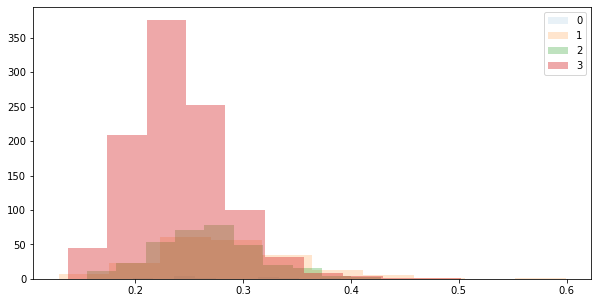

In [2107]:
plt.figure(figsize = (10,5))
plt.hist(essay_5.loc[essay_5["score_new"] == 0, "cos_simil"], label = '0', alpha = 0.1)
plt.hist(essay_5.loc[essay_5["score_new"] == 1, "cos_simil"], label = '1', alpha = 0.2)
plt.hist(essay_5.loc[essay_5["score_new"] == 2, "cos_simil"], label = '2', alpha = 0.3)
plt.hist(essay_5.loc[essay_5["score_new"] == 3, "cos_simil"], label = '3', alpha = 0.4)

plt.legend()

#### 점수가 높아질수록 코사인 유사도가 낮아지는 특이한 패턴을 보이고 있다.

확인이 필요하다.

In [2108]:
from itertools import permutations
a = essay_5["score_new"].unique()
permute = list(permutations(a,2))


In [2109]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_5.loc[essay_5["score_new"] == i[0],"cos_simil"], 
                              essay_5.loc[essay_5["score_new"] == i[1],"cos_simil"],equal_var = False)[1])

In [2110]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(3.0, 2.0)",8.304093e-20,True
1,"(3.0, 1.0)",6.029044e-18,True
2,"(3.0, 0.0)",3.909156e-02,True
3,"(2.0, 3.0)",8.304093e-20,True
4,"(2.0, 1.0)",1.532819e-03,True
5,"(2.0, 0.0)",4.033065e-01,False
6,"(1.0, 3.0)",6.029044e-18,True
7,"(1.0, 2.0)",1.532819e-03,True
8,"(1.0, 0.0)",9.697883e-01,False
9,"(0.0, 3.0)",3.909156e-02,True


고득점일수록 오히려 유사도가 낮아지는 자세한 이유에 대하여는 추가 분석이 필요하나, 

대체로 저득점 사례의 경우 문장 길이가 짧은 경우가 많고, 따라서

발제문을 그대로 '배낀' 경우 좋은 점수를 받지 못한 것으로 추정 가능하다.

### 결론 2 : 코사인 유사도는 일부 짝에 대해서는 차이가 유의미하다. 파생 변수 후보군으로 추가한다.

In [2113]:
sp = spacy.load('en_core_web_sm')

각 에세이에서 단어, 품사(대), 품사(소), 원형, 문장 성분을 추출한다.

해당 데이터를 Essay_id로 묶는다.

In [2114]:
pos_tagging = [list(map(lambda x : 
                       [essay_5.loc[i, "essay_id"], x.text, x.pos_, x.tag_, x.lemma_, x.dep_], 
                       sp(essay_5["essay"][i]))) 
              for i in range(0, len(essay_5))]

result = DataFrame(columns = ["essay_id", "word","pos","tag","lemma","depend"])

for i in range(0, len(pos_tagging)):
    result = pd.concat([result, DataFrame(pos_tagging[i], columns = ["essay_id","word","pos","tag","lemma","depend"])])

In [2115]:
result = result.reset_index(drop = True)

result의 포함된 결과물은 다음과 같다.

essay_id : 에세이 번호

word : 단어

pos : 품사(대분류, 명사 등)

tag : 품사(소분류, 대명사 등)

lemma : 원형

depend ; 문장 성분(주어, 목적어 등)

In [2116]:
# 결과물 예시

result

,essay_id,word,pos,tag,lemma,depend
0,17834,Patience,NOUN,NN,patience,nsubj
1,17834,is,AUX,VBZ,be,ROOT
2,17834,when,ADV,WRB,when,advmod
3,17834,your,PRON,PRP$,your,poss
4,17834,waiting,VERB,VBG,wait,nsubj
...,...,...,...,...,...,...
300670,19563,liked,VERB,VBD,like,ROOT
300671,19563,it,PRON,PRP,it,dobj
300672,19563,a,DET,DT,a,det
300673,19563,lot,NOUN,NN,lot,npadvmod


In [2117]:
sen_count = essay_5["essay"].apply(lambda x : len(nltk.sent_tokenize(x))).reset_index(name = "sen_count")

sen_count.columns = ["essay_id","sen_count"]

In [2118]:
len_count = result.groupby("essay_id")["lemma"].count().reset_index()

len_count.columns = ["essay_id","len_count"]

In [2119]:
## 각 품사를 총 단어 갯수로 나눔

count_result = DataFrame({"essay_id" : result["essay_id"].unique()})

for i in result["tag"].unique():

    test = result[result["tag"] == i]

    lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()
    
    count = pd.merge(lemma_count, len_count)

    count["{}_ratio".format(i)] = count["lemma"] / count["len_count"]
    
    count_result = pd.merge(count_result, count, how = "left")

In [2120]:
## NaN인 경우는 해당 품사가 없다는 의미이므로 0으로 처리해준다.

count_result = count_result.fillna(0)

In [2121]:
count_result = pd.merge(count_result, essay_5[["essay_id","score_new","score"]])

Boruta 알고리즘은 RF를 활용하여 1) 의미를 갖는 실제 변수 2) Random Shuffle 하여 의미를 가지지 않는 변수 
간의 변수 중요도를 구해 비교한다.

Random Shuffle한 변수보다 실제 변수의 변수 중요도가 낮다면, 그 변수는 예측에 도움이 되지 않는 변수로 간주할 수 있다.

In [2122]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y

X = count_result.loc[:,"NN_ratio" : "$_ratio"].values
y = count_result["score_new"].values
y = y.ravel()


rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

feat_selector.fit(X, y)

feat_selector.support_

feat_selector.ranking_

X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	48
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


In [2123]:
DataFrame({"col" : count_result.loc[:,"NN_ratio" : "$_ratio"].columns, "TF" : feat_selector.support_})

,col,TF
0,NN_ratio,True
1,VBZ_ratio,False
2,WRB_ratio,False
3,PRP$_ratio,False
4,VBG_ratio,False
5,VBD_ratio,False
6,IN_ratio,False
7,RB_ratio,False
8,UH_ratio,False
9,DT_ratio,False


#### NN_RATIO가 점수 구분에 유의미한 변수로 선정되었다.

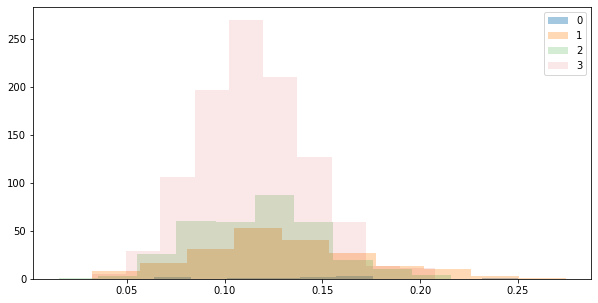

In [2124]:
plt.figure(figsize = (10,5))
plt.hist(count_result.loc[count_result["score_new"] == 0, "NN_ratio"], label = '0', alpha = 0.4)
plt.hist(count_result.loc[count_result["score_new"] == 1, "NN_ratio"], label = '1', alpha = 0.3)
plt.hist(count_result.loc[count_result["score_new"] == 2, "NN_ratio"], label = '2', alpha = 0.2)
plt.hist(count_result.loc[count_result["score_new"] == 3, "NN_ratio"], label = '3', alpha = 0.1)

plt.legend()

In [2125]:
count_result.groupby("score_new")["NN_ratio"].apply(lambda x : np.mean(x))

score_new
0.0    0.142584
1.0    0.130399
2.0    0.117724
3.0    0.115060
Name: NN_ratio, dtype: float64

In [2126]:
from itertools import permutations
a = essay_5["score_new"].unique()
permute = list(permutations(a,2))


In [2127]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_5.loc[essay_5["score_new"] == i[0],"cos_simil"], 
                              essay_5.loc[essay_5["score_new"] == i[1],"cos_simil"],equal_var = False)[1])

In [2128]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(3.0, 2.0)",8.304093e-20,True
1,"(3.0, 1.0)",6.029044e-18,True
2,"(3.0, 0.0)",3.909156e-02,True
3,"(2.0, 3.0)",8.304093e-20,True
4,"(2.0, 1.0)",1.532819e-03,True
5,"(2.0, 0.0)",4.033065e-01,False
6,"(1.0, 3.0)",6.029044e-18,True
7,"(1.0, 2.0)",1.532819e-03,True
8,"(1.0, 0.0)",9.697883e-01,False
9,"(0.0, 3.0)",3.909156e-02,True


점수가 높을수록 NN_RATIO는 낮아지는 형태를 확인할 수 있다.

NN_ratio는 총 단어 중 명사형 단어의 비율로, 

인내(Patience)에 대해 적절히 묘사하기 위해서는 명사보단 기타 상황을 묘사할 수 있는 품사들의 사용이 고득점에 보다 중요하게 작용한다고 유추할 수 있다.

### 결론 3 : NN_ratio는 일부 짝에 대해서는 유의미하다. 파생 변수 후보군으로 추가한다.

EDA 결과 문장 길이, 코사인 유사도, 명사 비율(NN_ratio)가 

써볼법한 추가 파생변수로 도출되었다.  동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [1934]:
encoding_result = DataFrame()

for i in essay_5["essay_id"].unique():
    text = essay_5.loc[essay_5["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_5, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")

In [1935]:
train_df = pd.merge(train_df, count_result[["essay_id","NN_ratio"]])

In [2166]:
# Default



columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.559796437659033

In [2165]:
# NN_ratio 포함

columns = [i for i in range(0, 39755)]

columns.extend(["NN_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.6157760814249365

In [2164]:
columns = [i for i in range(0, 39755)]

columns.extend(["cos_simil"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.4783715012722647

In [2163]:
columns = [i for i in range(0, 39755)]

columns.extend(["NN_ratio","cos_simil"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.519083969465649

In [2162]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.append("sen_len")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.33587786259542

In [2175]:
# sen_len, nn_ratio 포함(Best Score)

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len", "NN_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.3256997455470736

In [2160]:
# cos_simil, sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len", "cos_simil"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.351145038167939

In [2159]:
# cos_simil, sen_len 포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len", "cos_simil", "NN_ratio"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

2.356234096692112

#### 변수중요도

가장 성능이 좋았던 sen_len, nn_ratio 포함 모델의 변수 중요도는 아래와 같다.

In [2176]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)

,col,importance
39755,sen_len,0.529106
39756,NN_ratio,0.015345
14130,14130,0.006603
378,378,0.006339
32723,32723,0.005753
...,...,...
14410,14410,0.000000
14411,14411,0.000000
14412,14412,0.000000
14413,14413,0.000000


## 6) Essay_6

## (0) 데이터 전반

#### - EDA용 데이터 전처리

In [2177]:
essay_6 = essay[essay["essay_set"] == 6].reset_index(drop = True)

In [2178]:
essay_6["sen_len"] = essay_6["essay"].apply(lambda x : len(x))

#### - 점수별 분포

<AxesSubplot:>

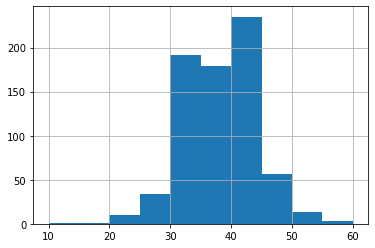

In [2179]:
essay_6["score"].hist()

### (1) 점수와 문장 길이

In [2180]:
essay_6.groupby("score")["sen_len"].mean().reset_index()

,score,sen_len
0,10,21.000000
1,15,1278.000000
2,20,887.000000
3,21,542.000000
4,22,927.000000
5,24,770.666667
6,25,1761.600000
7,26,1427.000000
8,27,1932.000000
9,28,1598.090909


점수가 높아질수록 문장 길이도 길어지는 양상을 보인다.

실제로 그런지 검정이 필요하다.

In [2181]:
essay_6.loc[essay_6["score"] < 27,"score_new"] = 0

In [2182]:
essay_6.loc[(essay_6["score"] >= 27) & (essay_6["score"] < 35),"score_new"] = 1

In [2183]:
essay_6.loc[(essay_6["score"] >= 35) & (essay_6["score"] < 44),"score_new"] = 2

In [2184]:
essay_6.loc[essay_6["score"] >= 44,"score_new"] = 3

1 ~ 12점 척도인 점수를 0 ~ 4 척도로 구분

In [2185]:
## 고득점 사례 모음

essay_6[essay_6["score_new"] == 3]

,essay_id,essay_set,essay,score,sen_len,score_new
1,20717,6,Softball has to be one of the single most gre...,46,3957,3.0
11,20728,6,Starting a story out with two NUM1 DATE1 old ...,44,4696,3.0
16,20736,6,"""Laughter"" A good relationship ...",45,3795,3.0
26,20751,6,"It was a normal bright and warm DATE1 day, g...",45,3073,3.0
32,20759,6,"As I waited in the car, anxious to meet my be...",47,3842,3.0
...,...,...,...,...,...,...
673,21563,6,The sound of laughter could be one that break...,46,3809,3.0
676,21567,6,Laughter I've always been one who laughs a lot...,45,3464,3.0
698,21599,6,"I sat at the table, speechless, as they told ...",47,4352,3.0
704,21607,6,LAUGHTER CAPS1 knows that laughter is a heali...,48,4451,3.0


In [2186]:
## 저득점 사례 모음

essay_6[essay_6["score_new"] == 0]

,essay_id,essay_set,essay,score,sen_len,score_new
4,20721,6,Well ima tell a story about the time i got CAP...,26,2914,0.0
15,20735,6,one time when i was skateboarding with my fri...,20,729,0.0
98,20839,6,One day me and my friend taylor got the idea o...,24,782,0.0
122,20871,6,Laughter is good for every one.CAPS1 helps the...,20,353,0.0
191,20954,6,DUE you think that being part of sameting f...,15,1278,0.0
202,20967,6,I was raised with two brother that mean the wo...,20,2296,0.0
237,21013,6,I think that laughter is very important. It is...,24,1114,0.0
252,21031,6,My newest botfriend and i have been dateing f...,25,3890,0.0
340,21140,6,Laughter...What is laughter? Laughter is what...,24,416,0.0
371,21177,6,The mood was sweet and the room was worm with ...,26,1283,0.0


In [2187]:
model = ols('sen_len ~ score_new',essay_6).fit()
anova_result = anova_lm(model)

In [2213]:
# 저득점 사례

essay_6.loc[472, "essay"]

'I was selling some cookie dough for school and i waent to this olderly guys house. I went through the hole deal of raising money for my school and he said he was not interested. After that we got to talking i started making him laugh and eventaully he said "you make me laugh i like that i will buy some". I think that the laughter pklayed a key roll in him buying the cookie dough.'

In [2214]:
# 고득점 사례

essay_6.loc[82, "essay"]

'Laughter\'s CAPS1 Laughter is everywhere. It MONTH1 be three doors down reclining in a comfy living room. It MONTH1 be at the nearest playground bouncing on the teeter-totter. It MONTH1 be at an elegant restaurant sitting at a petite table in the distant corner. For me, it lingered in an old fifth grade classroom. I stumbled through the doorway carrying CAPS11 purple backpack and CAPS11 lunch pale resting in CAPS11 left hand. I recognized everyone from CAPS11 previous years of elementary school, and shortly joined them after visiting CAPS11 hook outside the door. I had been waiting anxiously for CAPS11 turn at the fifth grade. The legendary PERSON1, was known as the "coolest" teacher around. He played a large role in the gossip of the young students, and each of us had our hopes set high. "CAPS2 your seats NUM1 graders!" announced PERSON1 CAPS3 with a contagious smile. Kids scattered around to room searching for seats near their closest friends. Everyone listened attentively to PERSON

### - 정규성 검정

In [2046]:
essay_6["resid"] = model.resid

In [2047]:
essay_6["fitted"] = model.fittedvalues

In [2048]:
essay_6.groupby(["score_new"])["resid"].apply(lambda x : scipy.stats.shapiro(x))

score_new
0.0     (0.8388091921806335, 0.002741594333201647)
1.0    (0.955970287322998, 3.3539072319399565e-06)
2.0     (0.9571970105171204, 2.18666107443255e-09)
3.0     (0.9553717970848083, 0.004746481776237488)
Name: resid, dtype: object

shapiro-wilk 결과 잔차는 정규분포를 따르지 않는 것으로 보인다.

그러나, 데이터 샘플 수가 커질수록 Normality Test 는 무조건 기각되는 경향이 있다.

QQplot을 그려 추가적으로 확인한다.

### - QQPLOT

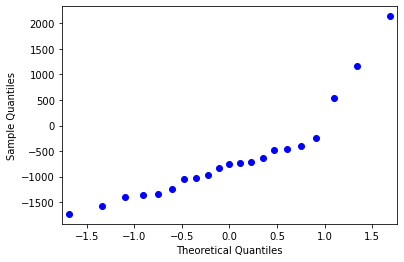

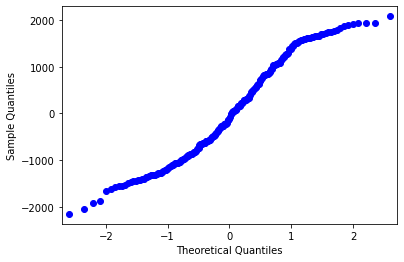

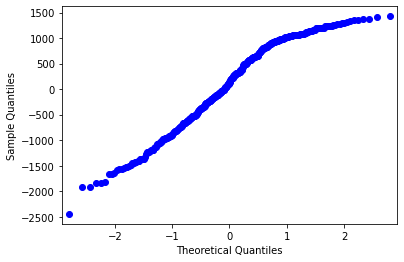

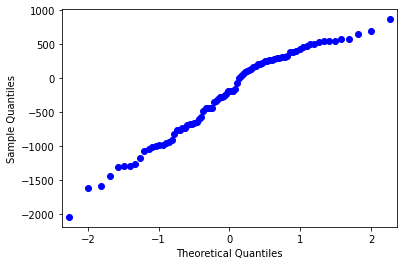

In [2049]:
import numpy as np
import statsmodels.api as sm
import pylab

essay_6.groupby(["score_new"])["resid"].apply(lambda x : sm.qqplot(x))
pylab.show()

잔차는 정규성을 만족하지 못하고 있다.

ANOVA는 사용할 수가 없다.

#### - T-TEST

CLT에 의해 정당화 가능한 평균검정법인 T-TEST로 각 짝에 대하여 검정한다.

In [2050]:
from itertools import permutations
a = essay_6["score_new"].unique()
permute = list(permutations(a,2))


In [2051]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_6.loc[essay_6["score_new"] == i[0],"sen_len"], 
                              essay_6.loc[essay_6["score_new"] == i[1],"sen_len"],equal_var = False)[1])

In [2052]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(1.0, 3.0)",6.407110e-30,True
1,"(1.0, 2.0)",4.521918e-21,True
2,"(1.0, 0.0)",4.420881e-07,True
3,"(3.0, 1.0)",6.407110e-30,True
4,"(3.0, 2.0)",5.098471e-08,True
5,"(3.0, 0.0)",1.381872e-12,True
6,"(2.0, 1.0)",4.521918e-21,True
7,"(2.0, 3.0)",5.098471e-08,True
8,"(2.0, 0.0)",1.902986e-10,True
9,"(0.0, 1.0)",4.420881e-07,True


모든 조합(짝)에서 각 Score별로 평균에는 유의미한 차이가 존재한다.

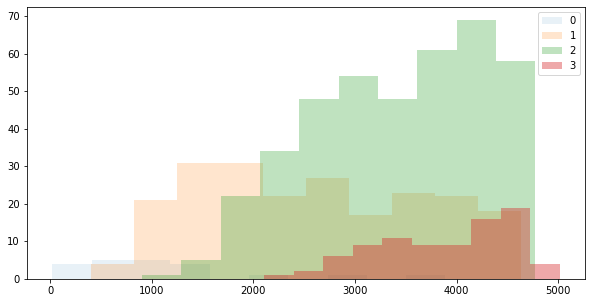

In [2053]:
plt.figure(figsize = (10,5))
plt.hist(essay_6.loc[essay_6["score_new"] == 0, "sen_len"], label = '0', alpha = 0.1)
plt.hist(essay_6.loc[essay_6["score_new"] == 1, "sen_len"], label = '1', alpha = 0.2)
plt.hist(essay_6.loc[essay_6["score_new"] == 2, "sen_len"], label = '2', alpha = 0.3)
plt.hist(essay_6.loc[essay_6["score_new"] == 3, "sen_len"], label = '3', alpha = 0.4)

plt.legend()

### 결론 1 : 고득점자는 상대적으로 긴 문장을 쓰는 경향이 있다.

## (2) 발제문과 정답간 유사도

가설 : 발제문을 벡터화하여 Essay와의 일치도를 본다. 점수가 높을수록 평가 기준과의 코사인 유사도는 높을 것이라 가설을 세울 수 있다.

#### - 발제문 벡터화

In [2206]:
criterion = '"If you want a place in the sun, you will have to expect some blisters." Tell a true story about a time when this quote was true for you or someone you know.'

In [2207]:
pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(criterion)))

In [2208]:
result_criterion = DataFrame(columns = ["lemma"])

for i in range(0, len(pos_tagging)):
    result_criterion = pd.concat([result_criterion, 
                                  DataFrame(pos_tagging[i], 
                                            columns = ["lemma"])])

In [2209]:
morphs = list(result_criterion["lemma"])

In [2210]:
morphsVectored_criterion = list()

## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.

for i in morphs:
    temporailyList = list()
    #print(k)
    try:
        # 색인사전에 있는 단어면 인덱스를 반환
        temporailyList.append(vocabulary[i])
    except KeyError:
        # 없는 단어면 0으로 대체한다.
        temporailyList.append(0)
    morphsVectored_criterion.append(temporailyList)


In [2211]:
vector_shell = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

In [2212]:
vector_shell[np.reshape(np.array(morphsVectored_criterion),[-1])] = 1

In [2215]:
cos_simil = list()

for i in essay_6["essay_id"].unique():
    text = essay_6.loc[essay_6["essay_id"] == i, "essay"]
    
    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))
    
    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])
        
    morphs = list(result_text["lemma"])
    
    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)
        
    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])
    
    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1
    
    simil_result = vector_shell_text.dot(vector_shell) / (np.linalg.norm(vector_shell_text) * np.linalg.norm(vector_shell))
    
    cos_simil.append(simil_result)

In [2216]:
essay_6["cos_simil"] = cos_simil

In [2217]:
essay_6.groupby("score_new")["cos_simil"].apply(lambda x : np.mean(x))

score_new
0.0    0.279532
1.0    0.271148
2.0    0.250256
3.0    0.231971
Name: cos_simil, dtype: float64

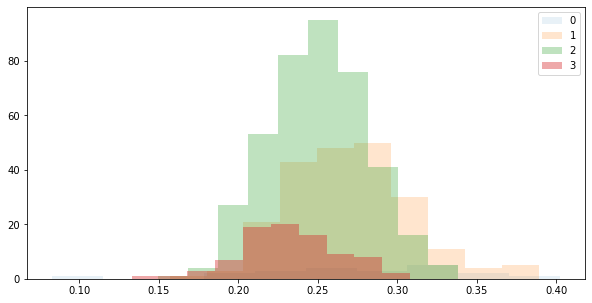

In [2218]:
plt.figure(figsize = (10,5))
plt.hist(essay_6.loc[essay_6["score_new"] == 0, "cos_simil"], label = '0', alpha = 0.1)
plt.hist(essay_6.loc[essay_6["score_new"] == 1, "cos_simil"], label = '1', alpha = 0.2)
plt.hist(essay_6.loc[essay_6["score_new"] == 2, "cos_simil"], label = '2', alpha = 0.3)
plt.hist(essay_6.loc[essay_6["score_new"] == 3, "cos_simil"], label = '3', alpha = 0.4)

plt.legend()

특이하게도, 점수가 높아질수록 코사인 유사도가 낮아지는 경향이 있다. 확인이 필요하다.

In [2219]:
from itertools import permutations
a = essay_6["score_new"].unique()
permute = list(permutations(a,2))


In [2220]:
result_list = list()

for i in permute:
    result_list.append(
        scipy.stats.ttest_ind(essay_6.loc[essay_6["score_new"] == i[0],"cos_simil"], 
                              essay_6.loc[essay_6["score_new"] == i[1],"cos_simil"],equal_var = False)[1])

In [2221]:
# t-test 결과

DataFrame({"permute" : permute, "pvalue" : result_list, "test" : list(map(lambda x : x < 0.05, result_list))})

,permute,pvalue,test
0,"(1.0, 3.0)",3.708562e-16,True
1,"(1.0, 2.0)",4.384171e-11,True
2,"(1.0, 0.0)",5.996296e-01,False
3,"(3.0, 1.0)",3.708562e-16,True
4,"(3.0, 2.0)",4.488971e-06,True
5,"(3.0, 0.0)",6.689443e-03,True
6,"(2.0, 1.0)",4.384171e-11,True
7,"(2.0, 3.0)",4.488971e-06,True
8,"(2.0, 0.0)",7.459944e-02,False
9,"(0.0, 1.0)",5.996296e-01,False


### 결론 2 : 코사인 유사도는 일부 짝에 대해서는 차이가 유의미하다. 파생변수 후보군으로 추가한다.

In [2222]:
sp = spacy.load('en_core_web_sm')

각 에세이에서 단어, 품사(대), 품사(소), 원형, 문장 성분을 추출한다.

해당 데이터를 Essay_id로 묶는다.

In [2223]:
pos_tagging = [list(map(lambda x : 
                       [essay_6.loc[i, "essay_id"], x.text, x.pos_, x.tag_, x.lemma_, x.dep_], 
                       sp(essay_6["essay"][i]))) 
              for i in range(0, len(essay_6))]

result = DataFrame(columns = ["essay_id", "word","pos","tag","lemma","depend"])

for i in range(0, len(pos_tagging)):
    result = pd.concat([result, DataFrame(pos_tagging[i], columns = ["essay_id","word","pos","tag","lemma","depend"])])

In [2224]:
result = result.reset_index(drop = True)

result의 포함된 결과물은 다음과 같다.

essay_id : 에세이 번호

word : 단어

pos : 품사(대분류, 명사 등)

tag : 품사(소분류, 대명사 등)

lemma : 원형

depend ; 문장 성분(주어, 목적어 등)

In [2225]:
# 결과물 예시

result

,essay_id,word,pos,tag,lemma,depend
0,20716,,SPACE,_SP,,ROOT
1,20716,A,DET,DT,a,det
2,20716,long,ADJ,JJ,long,amod
3,20716,time,NOUN,NN,time,npadvmod
4,20716,ago,ADV,RB,ago,advmod
...,...,...,...,...,...,...
492853,21633,as,ADV,RB,as,advmod
492854,21633,much,ADJ,JJ,much,advmod
492855,21633,as,ADP,IN,as,prep
492856,21633,anyone,PRON,NN,anyone,pobj


In [2226]:
sen_count = essay_6["essay"].apply(lambda x : len(nltk.sent_tokenize(x))).reset_index(name = "sen_count")

sen_count.columns = ["essay_id","sen_count"]

In [2227]:
len_count = result.groupby("essay_id")["lemma"].count().reset_index()

len_count.columns = ["essay_id","len_count"]

In [2228]:
## 각 품사를 총 단어 갯수로 나눔

count_result = DataFrame({"essay_id" : result["essay_id"].unique()})

for i in result["tag"].unique():

    test = result[result["tag"] == i]

    lemma_count = test.groupby("essay_id")["lemma"].count().reset_index()
    
    count = pd.merge(lemma_count, len_count)

    count["{}_ratio".format(i)] = count["lemma"] / count["len_count"]
    
    count_result = pd.merge(count_result, count, how = "left")

In [2229]:
## NaN인 경우는 해당 품사가 없다는 의미이므로 0으로 처리해준다.

count_result = count_result.fillna(0)

In [2230]:
count_result = pd.merge(count_result, essay_6[["essay_id","score_new","score"]])

Boruta 알고리즘은 RF를 활용하여 1) 의미를 갖는 실제 변수 2) Random Shuffle 하여 의미를 가지지 않는 변수 
간의 변수 중요도를 구해 비교한다.

Random Shuffle한 변수보다 실제 변수의 변수 중요도가 낮다면, 그 변수는 예측에 도움이 되지 않는 변수로 간주할 수 있다.

In [2197]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# load X and y

X = count_result.loc[:,"_SP_ratio" : "$_ratio"].values
y = count_result["score_new"].values
y = y.ravel()


rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

feat_selector.fit(X, y)

feat_selector.support_

feat_selector.ranking_

X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	48
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	48


In [2198]:
DataFrame({"col" : count_result.loc[:,"_SP_ratio" : "$_ratio"].columns, "TF" : feat_selector.support_})

,col,TF
0,_SP_ratio,True
1,DT_ratio,False
2,JJ_ratio,False
3,NN_ratio,False
4,RB_ratio,False
5,WRB_ratio,False
6,PRP_ratio,False
7,VBD_ratio,False
8,IN_ratio,False
9,CD_ratio,False


#### SP_ratio가 점수 구분에 유의미한 변수로 선정되었다.

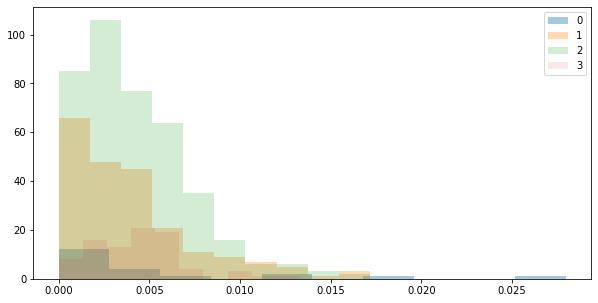

In [2199]:
plt.figure(figsize = (10,5))
plt.hist(count_result.loc[count_result["score_new"] == 0, "_SP_ratio"], label = '0', alpha = 0.4)
plt.hist(count_result.loc[count_result["score_new"] == 1, "_SP_ratio"], label = '1', alpha = 0.3)
plt.hist(count_result.loc[count_result["score_new"] == 2, "_SP_ratio"], label = '2', alpha = 0.2)
plt.hist(count_result.loc[count_result["score_new"] == 3, "_SP_ratio"], label = '3', alpha = 0.1)

plt.legend()

In [2245]:
# 점수 대비 비교

count_result.groupby("score_new")["_SP_ratio"].apply(lambda x : np.mean(x))

score_new
0.0    0.004588
1.0    0.003898
2.0    0.004296
3.0    0.004392
Name: _SP_ratio, dtype: float64

도출된 SP_ratio 는 띄어쓰기와 관련된 구분자이다.

띄어쓰기는 활용하기에 의미가 없고, 점수 대비 비교해봐도 어떤 패턴을 발견할 수 없다.

### 결론 3 : Boruta 알고리즘 검정 결과 유의미한 품사로 SP가 도출되었으나, 추가 분석을 진행해본 결과 활용은 어렵다.

EDA 결과 문장 길이, 코사인 유사도가 

써볼법한 추가 파생변수로 도출되었다.  동일 조건하에 RF모델을 적합하여 베이스라인(Default)대비 변수 추가시 성능 향상이 있는지 검증한다.

In [2837]:
encoding_result = DataFrame()

for i in essay_6["essay_id"].unique():
    text = essay_6.loc[essay_6["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_6, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")

In [2838]:
# Default



columns = [i for i in range(0, 39755)]

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

3.430939226519337

In [2839]:
#cos_simil 포함

columns = [i for i in range(0, 39755)]

columns.extend(["cos_simil"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

3.403314917127072

In [2840]:
# sen_len 포함

columns = [i for i in range(0, 39755)]

columns.append("sen_len")

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

3.287292817679558

In [2841]:
# sen_len, cos_simil,  포함

columns = [i for i in range(0, 39755)]

columns.extend(["sen_len", "cos_simil"])

columns = np.array(columns)

train_x, val_x, train_y, val_y = train_test_split(train_df[columns.astype("str")], 
                                                  train_df["score"],
                                                 random_state = 42)

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)

rf.fit(train_x, train_y)

predicted = np.round(rf.predict(val_x))

sklearn.metrics.mean_absolute_error(val_y, predicted)

3.2154696132596685

가장 성능이 좋았던 sen_len, cos_simil 포함 모델의 변수중요도는 아래와 같다.

#### 변수중요도

In [2244]:
DataFrame({"col" : columns, "importance" : rf.feature_importances_}).sort_values(by = "importance", ascending = False)

,col,importance
39755,sen_len,0.327648
39756,cos_simil,0.065521
34814,34814,0.031308
30312,30312,0.013043
23962,23962,0.011133
...,...,...
13761,13761,0.000000
13762,13762,0.000000
13763,13763,0.000000
13764,13764,0.000000


## 3. 결론 및 추가 분석 필요 진행 사항

### 1. EDA 결론

### 1) Essay3, Essay 4의 경우 코사인 유사도와 점수 사이에는 정비례하는 관계가 있다.
(1) 이는 3, 4가 발제문의 내용을 요약하는 경우로서 발제문을 잘 요약할수록 높은 점수를 받았기 때문으로 추정 가능하다.

### 2) Essay 5, Essay 6의 경우 코사인 유사도와 점수 사이에는 반비례하는 관계가 있다. 

(1) 이는 저득점자의 경우 짧은 문장 길이에 상대적으로 발제문을 '그대로 배껴' 제출한 경우가 많고, 이 경우 낮은 점수를 받았다고 추정할 수 있다.

### 3) 일부 에세이의 경우 '품사 / 단어 갯수' 비율이 쓸 수 있는 파생변수로 도출되었다.

#### (1) Essay2의 경우 형용사 비율(JJ Ratio)와 부사절 접속사 비율(SCONJ_ratio)가 성능 향상에 도움이 되는 변수로 작용했다. 

(1) 이는 '공격적인 출판물이 도서관에서 검열되어야 하는가?'에 대한 논증을 펼치는 주제를 제시했으므로, 공격적인 상황을 구체적으로 묘사하는 형용사와 설득적인 부사절 접속사를 잘 사용할수록 고득점을 받았을 것이라고 추정할 수 있다.

## 2. 추가 분석 진행 사항

### 1) 문장당 평균 단어 갯수 : 
(1)문장이 길어질수록 평가자는 고득점을 매기는 경향이 있는가? 에 대한 가설 검정 필요

### 2) 점수를 고려한 Word-Embedding 

(1) CBOW 알고리즘에 에세이 점수(Essay Score)를 고려하는 Output Dense를 추가

(2) 점수를 동시에 고려 가능한 확장 Word-Embedding으로 고득점 임베딩 벡터를 분석 (Alikaniotis et al. 2016)

### 3) 문장 흐름을 고려한 에세이 - 발제문간 유사도 훈련 및 임베딩 벡터 분석

(1) 현제 진행한 방식은 단순히 에세이 / 발제문에 등장한 단어들을 1로 표현한 벡터의 코사인 유사도를 도출

(2) 위 방식은 단어간의 관계를 고려하지 못하고, 단어의 등장 횟수도 고려하지 못함

(3) 아래 작성한 코드를 발전시켜, 에세이 - 발제문간 Attention-LSTM 모델을 Essay Score 점수로 훈련 후 고득점 Essay 사례의 임베딩 벡터를 분석 실시

In [1152]:
encoding_result = DataFrame()

for i in essay_4["essay_id"].unique():
    text = essay_4.loc[essay_4["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    vector_shell_text = np.array([0 for i in range(0, np.max(list(vocabulary.values())) + 1)])

    vector_shell_text[np.reshape(np.array(morphsVectored),[-1])] = 1

    encoding_result = pd.concat([encoding_result, DataFrame(vector_shell_text).T])


train_df = pd.concat([essay_4, encoding_result.reset_index(drop = True)], axis = 1)

train_df.columns = train_df.columns.astype("str")

In [1376]:
encoding_result = list()

for i in essay_4["essay_id"].unique():
    text = essay_4.loc[essay_4["essay_id"] == i, "essay"]

    pos_tagging = list(map(lambda x : 
                       [x.lemma_], 
                       sp(text.values[0])))

    result_text = DataFrame(columns = ["lemma"])

    for j in range(0, len(pos_tagging)):
        result_text = pd.concat([result_text,
                                      DataFrame(pos_tagging[j], 
                                                columns = ["lemma"])])

    morphs = list(result_text["lemma"])
    
    morphs.insert(0, "CLS")

    morphsVectored = list()

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    for j in morphs:
        temporailyList = list()
        #print(k)
        try:
            # 색인사전에 있는 단어면 인덱스를 반환
            temporailyList.append(vocabulary[j])
        except KeyError:
            # 없는 단어면 0으로 대체한다.
            temporailyList.append(0)
        morphsVectored.append(temporailyList)

    encoding_result.append(list(np.reshape(morphsVectored, [1,-1])[0]))

In [1416]:
# text classification

encoding_result = sequence.pad_sequences(encoding_result ,maxlen = 300, padding = 'post', truncating = 'post')
encoding_criterion = sequence.pad_sequences(np.reshape(morphsVectored_criterion, [1,-1]) ,maxlen = 300, padding = 'post', truncating = 'post')

In [1493]:
class SAWE(tf.keras.Model):
    def __init__(self, 
                 dense_dim,
                vocab_size):        
        super(SAWE, self).__init__()
        self.dense_dim = dense_dim
        self.vocab_size = vocab_size
     
    def build(self, input_shape):
    
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   self.dense_dim)
        
        self.LSTM_input = tf.keras.layers.LSTM(self.dense_dim,
                                              return_sequences = True)
        
        self.LSTM_prompt = tf.keras.layers.LSTM(self.dense_dim,
                                               return_sequences = True)
        
        self.queries = tf.keras.layers.Dense(self.dense_dim)
        
        self.keys = tf.keras.layers.Dense(self.dense_dim)
        
        self.values = tf.keras.layers.Dense(self.dense_dim)
        
        self.output_layer = tf.keras.layers.Dense(1,
                                           activation = "relu")
        
    def call(self, input_tensor):       
        
        
        embedding_input = self.embedding(input_tensor[0])
        
        input_output = self.LSTM_input(embedding_input)
        
        
        embedding_prompt = self.embedding(input_tensor[1])
        
        prompt_output = self.LSTM_prompt(embedding_prompt)
        
        query = self.queries(input_output)
        
        key = self.keys(prompt_output)
        
        value = self.values(input_output)
        
        query_key = tf.keras.layers.Dot(axes = 2)([query,key])
        
        query_key = tf.keras.layers.Lambda(lambda x: (x / np.sqrt(self.dense_dim)))(query_key)
        
        query_key = tf.keras.layers.Softmax()(query_key)
        
        attention = tf.keras.layers.Dot(axes=1)([query_key,value])
        
        cls_token = tf.keras.layers.Lambda(lambda x : x[:,0,:])(attention)

        output = self.output_layer(cls_token)
        
        return output

In [1494]:
lstm_attention = SAWE(200, 
           len(vect.vocabulary_) + 1)

In [1500]:
@tf.function()
def training_SWAE(inp, prompt , tar):
    with tf.GradientTape() as tape:
        
        output = lstm_attention((inp, prompt))

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, lstm_attention.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_attention.trainable_variables))
  
    train_loss(loss)
    accuracy_function(tar,  output)

In [1501]:
def val_accuracy(inp, tar, Models):
    output = Models(inp)
    
    test_accuracy(tar, output)

In [1502]:
EPOCHS = 200

In [1503]:
input_train, input_val, y_train, y_val = train_test_split(encoding_result, essay_4["score"])

In [1504]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='train_loss')
test_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

accuracy_function = tf.keras.metrics.MeanAbsoluteError()

loss_function = tf.keras.losses.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    for i in range(0, len(input_train)):

        inputs = input_train[i]

        inputs = tf.Variable(np.reshape(inputs, [1, -1]), dtype = tf.float32)

        prompt = tf.Variable(np.reshape(encoding_criterion, [1, -1]), dtype = tf.float32)

        tar = np.reshape(np.array(y_train)[i], [-1,1])

        training_SWAE(inputs, prompt, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {accuracy_function.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    val_accuracy((input_val, tf.repeat(prompt, len(input_val), axis = 0)),  y_val, lstm_attention)
    print(f' TestAccuracy {test_accuracy.result():.4f}')

Epoch 1 Batch 0 Loss 0.0631 Accuracy 0.0631
Epoch 1 Batch 5 Loss 0.7494 Accuracy 0.7494
Epoch 1 Batch 10 Loss 0.7198 Accuracy 0.7198
Epoch 1 Batch 15 Loss 0.6493 Accuracy 0.6493
Epoch 1 Batch 20 Loss 0.6260 Accuracy 0.6260
Epoch 1 Batch 25 Loss 0.5815 Accuracy 0.5815
Epoch 1 Batch 30 Loss 0.5401 Accuracy 0.5401
Epoch 1 Batch 35 Loss 0.5428 Accuracy 0.5428
Epoch 1 Batch 40 Loss 0.5357 Accuracy 0.5357
Epoch 1 Batch 45 Loss 0.5276 Accuracy 0.5276
Epoch 1 Batch 50 Loss 0.5276 Accuracy 0.5276
Epoch 1 Batch 55 Loss 0.5281 Accuracy 0.5281
Epoch 1 Batch 60 Loss 0.5681 Accuracy 0.5681
Epoch 1 Batch 65 Loss 0.5815 Accuracy 0.5815
Epoch 1 Batch 70 Loss 0.5625 Accuracy 0.5625
Epoch 1 Batch 75 Loss 0.5780 Accuracy 0.5780
Epoch 1 Batch 80 Loss 0.5747 Accuracy 0.5747
Epoch 1 Batch 85 Loss 0.5530 Accuracy 0.5530
Epoch 1 Batch 90 Loss 0.5455 Accuracy 0.5455
Epoch 1 Batch 95 Loss 0.5357 Accuracy 0.5357
Epoch 1 Batch 100 Loss 0.5408 Accuracy 0.5408
Epoch 1 Batch 105 Loss 0.5321 Accuracy 0.5321
Epoch 1 Ba

Epoch 1 Batch 895 Loss 0.4786 Accuracy 0.4786
Epoch 1 Batch 900 Loss 0.4773 Accuracy 0.4773
Epoch 1 Batch 905 Loss 0.4774 Accuracy 0.4774
Epoch 1 Batch 910 Loss 0.4789 Accuracy 0.4789
Epoch 1 Batch 915 Loss 0.4798 Accuracy 0.4798
Epoch 1 Batch 920 Loss 0.4803 Accuracy 0.4803
Epoch 1 Batch 925 Loss 0.4794 Accuracy 0.4794
Epoch 1 Batch 930 Loss 0.4781 Accuracy 0.4781
Epoch 1 Batch 935 Loss 0.4774 Accuracy 0.4774
Epoch 1 Batch 940 Loss 0.4777 Accuracy 0.4777
Epoch 1 Batch 945 Loss 0.4769 Accuracy 0.4769
Epoch 1 Batch 950 Loss 0.4756 Accuracy 0.4756
Epoch 1 Batch 955 Loss 0.4753 Accuracy 0.4753
Epoch 1 Batch 960 Loss 0.4753 Accuracy 0.4753
Epoch 1 Batch 965 Loss 0.4755 Accuracy 0.4755
Epoch 1 Batch 970 Loss 0.4752 Accuracy 0.4752
Epoch 1 Batch 975 Loss 0.4760 Accuracy 0.4760
Epoch 1 Batch 980 Loss 0.4752 Accuracy 0.4752
Epoch 1 Batch 985 Loss 0.4740 Accuracy 0.4740
Epoch 1 Batch 990 Loss 0.4746 Accuracy 0.4746
Epoch 1 Batch 995 Loss 0.4743 Accuracy 0.4743
Epoch 1 Batch 1000 Loss 0.4737 Acc

Epoch 2 Batch 425 Loss 0.4599 Accuracy 0.4599
Epoch 2 Batch 430 Loss 0.4599 Accuracy 0.4599
Epoch 2 Batch 435 Loss 0.4596 Accuracy 0.4596
Epoch 2 Batch 440 Loss 0.4592 Accuracy 0.4592
Epoch 2 Batch 445 Loss 0.4602 Accuracy 0.4602
Epoch 2 Batch 450 Loss 0.4602 Accuracy 0.4602
Epoch 2 Batch 455 Loss 0.4599 Accuracy 0.4599
Epoch 2 Batch 460 Loss 0.4603 Accuracy 0.4603
Epoch 2 Batch 465 Loss 0.4599 Accuracy 0.4599
Epoch 2 Batch 470 Loss 0.4602 Accuracy 0.4602
Epoch 2 Batch 475 Loss 0.4599 Accuracy 0.4599
Epoch 2 Batch 480 Loss 0.4598 Accuracy 0.4598
Epoch 2 Batch 485 Loss 0.4607 Accuracy 0.4607
Epoch 2 Batch 490 Loss 0.4601 Accuracy 0.4601
Epoch 2 Batch 495 Loss 0.4604 Accuracy 0.4604
Epoch 2 Batch 500 Loss 0.4608 Accuracy 0.4608
Epoch 2 Batch 505 Loss 0.4611 Accuracy 0.4611
Epoch 2 Batch 510 Loss 0.4611 Accuracy 0.4611
Epoch 2 Batch 515 Loss 0.4601 Accuracy 0.4601
Epoch 2 Batch 520 Loss 0.4603 Accuracy 0.4603
Epoch 2 Batch 525 Loss 0.4604 Accuracy 0.4604
Epoch 2 Batch 530 Loss 0.4598 Accu

Epoch 2 Batch 1310 Loss 0.4459 Accuracy 0.4459
Epoch 2 Batch 1315 Loss 0.4456 Accuracy 0.4456
Epoch 2 Batch 1320 Loss 0.4454 Accuracy 0.4454
Epoch 2 Batch 1325 Loss 0.4456 Accuracy 0.4456
Epoch 2 Batch 1330 Loss 0.4458 Accuracy 0.4458
Epoch 2 Batch 1335 Loss 0.4460 Accuracy 0.4460
Epoch 2 Batch 1340 Loss 0.4463 Accuracy 0.4463
Epoch 2 Batch 1345 Loss 0.4463 Accuracy 0.4463
Time taken for 1 epoch: 314.23 secs

 TestAccuracy 2.9631
Epoch 3 Batch 0 Loss 0.4462 Accuracy 0.4462
Epoch 3 Batch 5 Loss 0.4466 Accuracy 0.4466
Epoch 3 Batch 10 Loss 0.4468 Accuracy 0.4468
Epoch 3 Batch 15 Loss 0.4464 Accuracy 0.4464
Epoch 3 Batch 20 Loss 0.4461 Accuracy 0.4461
Epoch 3 Batch 25 Loss 0.4459 Accuracy 0.4459
Epoch 3 Batch 30 Loss 0.4456 Accuracy 0.4456
Epoch 3 Batch 35 Loss 0.4461 Accuracy 0.4461
Epoch 3 Batch 40 Loss 0.4460 Accuracy 0.4460
Epoch 3 Batch 45 Loss 0.4462 Accuracy 0.4462
Epoch 3 Batch 50 Loss 0.4461 Accuracy 0.4461
Epoch 3 Batch 55 Loss 0.4461 Accuracy 0.4461
Epoch 3 Batch 60 Loss 0.4469

Epoch 3 Batch 850 Loss 0.4302 Accuracy 0.4302
Epoch 3 Batch 855 Loss 0.4301 Accuracy 0.4301
Epoch 3 Batch 860 Loss 0.4299 Accuracy 0.4299
Epoch 3 Batch 865 Loss 0.4299 Accuracy 0.4299
Epoch 3 Batch 870 Loss 0.4295 Accuracy 0.4295
Epoch 3 Batch 875 Loss 0.4291 Accuracy 0.4291
Epoch 3 Batch 880 Loss 0.4291 Accuracy 0.4291
Epoch 3 Batch 885 Loss 0.4286 Accuracy 0.4286
Epoch 3 Batch 890 Loss 0.4289 Accuracy 0.4289
Epoch 3 Batch 895 Loss 0.4289 Accuracy 0.4289
Epoch 3 Batch 900 Loss 0.4287 Accuracy 0.4287
Epoch 3 Batch 905 Loss 0.4285 Accuracy 0.4285
Epoch 3 Batch 910 Loss 0.4286 Accuracy 0.4286
Epoch 3 Batch 915 Loss 0.4292 Accuracy 0.4292
Epoch 3 Batch 920 Loss 0.4293 Accuracy 0.4293
Epoch 3 Batch 925 Loss 0.4289 Accuracy 0.4289
Epoch 3 Batch 930 Loss 0.4287 Accuracy 0.4287
Epoch 3 Batch 935 Loss 0.4286 Accuracy 0.4286
Epoch 3 Batch 940 Loss 0.4287 Accuracy 0.4287
Epoch 3 Batch 945 Loss 0.4284 Accuracy 0.4284
Epoch 3 Batch 950 Loss 0.4281 Accuracy 0.4281
Epoch 3 Batch 955 Loss 0.4278 Accu

KeyboardInterrupt: 